In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

Setting environment for Local Macbook Pro


# Global

Directly using local is sufficient

In [3]:
# stack_fixed = 'LM30'
# stack_fixed = 'LM40'
# stack_fixed = 'LM30new'
# stack_fixed = 'LM40new'
# stack_fixed = 'LM31'
# stack_fixed = 'LM38'
# stack_fixed = 'LM48'

# stack_fixed = 'LM42_LM37'
# stack_fixed = 'LM46'
# stack_fixed = 'LM22'
# stack_fixed = 'LM41'
# stack_fixed = 'LM86'
# stack_fixed = 'LM84'
# stack_fixed = 'LM32'
# stack_fixed = 'LM72'
stack_fixed = 'LM27'

stack_moving = 'atlasV5'

In [4]:
warp_setting = 24
# warp_setting = 16
# Adding surr is essential.

In [5]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment,max_iter_num
warp_id,,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000.0,2000.0,2000.0,30.0,0,NaN,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,10.0,0,0.000001,NaN,NaN
5,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,30.0,inverse,0.000000,NaN,NaN
6,1,affine,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,-0.5,0.000000,NaN,NaN
7,None,rigid,0.000001,100000.0,1000.0,50.0,50.0,50.0,10.0,0,NaN,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200.0,200.0,200.0,30.0,NaN,0.000000,align mid-sagittal planes,NaN
9,8,rigid,0.000001,100000.0,10000.0,2000.0,2000.0,2000.0,30.0,NaN,NaN,global registration given mid-sagittal planes ...,NaN
10,None,rigid,0.000010,100000.0,1000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN


In [6]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = int(warp_properties['grad_computation_sample_number'])
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

surround_weight = warp_properties['surround_weight']
if isinstance(surround_weight, float) or isinstance(surround_weight, int):
    surround_weight = float(surround_weight)
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
elif isinstance(surround_weight, str):
    surround_weight = str(surround_weight)
    # Setting surround_weight as inverse is very important. Using -1 often gives false peaks.
    include_surround = True
    
print surround_weight, include_surround

upstream_warp_id                                                               None
transform_type                                                               affine
terminate_thresh                                                                NaN
grad_computation_sample_number                                                10000
grid_search_sample_number                                                       NaN
std_tx_um                                                                      2000
std_ty_um                                                                      2000
std_tz_um                                                                      2000
std_theta_xy_degree                                                              30
surround_weight                                                             inverse
regularization_weight                                                           NaN
comment                           global reg with surr no grid search; count

In [418]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 20
# MAX_GRID_SEARCH_ITER_NUM = 30

lr1 = 10
lr2 = 0.1

In [419]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, sided=True, volume_type='score', 
#                                                       include_surround=include_surround,
                                                     structures=['3N_L', 'RMC_L', 'SNR_L',
                                                                '3N_L_surround_200', 'RMC_L_surround_200', 'SNR_L_surround_200'])
print volume_moving[1].shape

Prior structure/index map not found. Generating a new one.


(356, 427, 375)


Volume shape: (356, 427, 375)


In [420]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, sided=True, 
                                                      volume_type='annotationAsScore',
                                                     include_surround=include_surround,
                                                     structures=['3N_L', 'RMC_L', 'SNR_L',
                                                                '3N_L_surround_200', 'RMC_L_surround_200', 'SNR_L_surround_200'])

print volume_fixed[1].shape

Prior structure/index map not found. Generating a new one.


(187, 117, 188)


Volume shape: (187, 117, 188)


In [421]:
structure_subset = all_known_structures_sided

In [422]:
if include_surround:
    structure_subset = structure_subset + [convert_to_surround_name(s, margin=200) for s in structure_subset]

In [423]:
label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset and name_m in structure_to_label_fixed}

In [424]:
label_mapping_m2f

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

In [425]:
positive_weight = 'size'
# positive_weight = 'inverse'

In [426]:
cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                  volume_moving.keys())))
pool.close()
pool.join()

In [427]:
label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

In [428]:
label_weights_m

{1: 1.0,
 2: 0.08578068878090006,
 3: 1.0,
 4: 0.15379052789032086,
 5: 1.0,
 6: 0.40870655618253604}

In [429]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [430]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving['3N_L']])
# Sometimes initialize with SNR_L centers results in zero gradient. In those cases use another structure.

centroid_m: [  94.00685547  151.00359631  176.50280962], centroid_f: [  84.24779736   34.41795154  158.48127753]


In [431]:
aligner.set_label_weights(label_weights=label_weights_m)

In [432]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [433]:
gradient_filepath_map_f

{1: '/media/yuncong/YuncongPublic/CSHL_volumes/LM72/LM72_down32_annotationAsScoreVolume/score_volume_gradients/LM72_down32_annotationAsScoreVolume_3N_L_%(suffix)s.bp',
 2: '/media/yuncong/YuncongPublic/CSHL_volumes/LM72/LM72_down32_annotationAsScoreVolume/score_volume_gradients/LM72_down32_annotationAsScoreVolume_3N_L_surround_200_%(suffix)s.bp',
 3: '/media/yuncong/YuncongPublic/CSHL_volumes/LM72/LM72_down32_annotationAsScoreVolume/score_volume_gradients/LM72_down32_annotationAsScoreVolume_RMC_L_%(suffix)s.bp',
 4: '/media/yuncong/YuncongPublic/CSHL_volumes/LM72/LM72_down32_annotationAsScoreVolume/score_volume_gradients/LM72_down32_annotationAsScoreVolume_RMC_L_surround_200_%(suffix)s.bp',
 5: '/media/yuncong/YuncongPublic/CSHL_volumes/LM72/LM72_down32_annotationAsScoreVolume/score_volume_gradients/LM72_down32_annotationAsScoreVolume_SNR_L_%(suffix)s.bp',
 6: '/media/yuncong/YuncongPublic/CSHL_volumes/LM72/LM72_down32_annotationAsScoreVolume/score_volume_gradients/LM72_down32_annotati

In [434]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins; all 28, 220s

indices_f: set([1, 2, 3, 4, 5, 6])
load gradient 1: 0.137802 seconds
load gradient 2: 0.134697 seconds
load gradient 3: 0.132704 seconds
load gradient 4: 0.213939 seconds
load gradient 5: 0.177181 seconds
load gradient 6: 0.222625 seconds
overall: 1.019656 seconds


In [435]:
# aligner.grid_search(10)

In [436]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=transform_type, 
#                                      max_iter_num=100,
                                     max_iter_num=300,
                                     history_len=HISTORY_LEN, 
                                     terminate_thresh_rot=.002,
                                     terminate_thresh_trans=.2,
                                     grad_computation_sample_number=grad_computation_sample_number,
                                     lr1=1, lr2=.1,
#                                     init_T=grid_search_T, 
#                                      affine_scaling_limits=(.9, 1.2)
                                    )
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(aligner.Ts)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


iteration 0
in T: 0.00 0.00 0.00, out T: 1.00 1.00 -1.00
step: 0.13 seconds
current score: -0.674268
new_T: [ 1.  1. -1.]
det: 1.10

iteration 1
in T: 1.00 1.00 -1.00, out T: 1.73 1.81 -0.55
step: 0.12 seconds
current score: -0.670230
new_T: [ 1.73422177  1.80566755 -0.55206225]
det: 1.05

iteration 2
in T: 1.73 1.81 -0.55, out T: 0.90 0.96 -0.01
step: 0.15 seconds
current score: -0.671010
new_T: [ 0.8993785   0.9592486  -0.01397845]
det: 0.99

iteration 3
in T: 0.90 0.96 -0.01, out T: 1.40 1.51 -0.82
step: 0.12 seconds
current score: -0.671442
new_T: [ 1.40056234  1.50568127 -0.81658574]
det: 1.08

iteration 4
in T: 1.40 1.51 -0.82, out T: 0.93 1.10 -0.49
step: 0.14 seconds
current score: -0.670100
new_T: [ 0.93236011  1.09926894 -0.48792612]
det: 1.04

iteration 5
in T: 0.93 1.10 -0.49, out T: 1.38 1.49 -1.02
step: 0.14 seconds
current score: -0.670191
new_T: [ 1.37857813  1.48707816 -1.01992524]
det: 1.10

iteration 6
in T: 1.38 1.49 -1.02, out T: 1.16 1.06 -0.59
step: 0.12 seconds

in T: 1.94 0.02 -0.99, out T: 1.86 -0.00 -1.05
step: 0.08 seconds
current score: -0.669482
new_T: [ 1.86201311 -0.00396688 -1.04573488]
det: 1.02

iteration 54
in T: 1.86 -0.00 -1.05, out T: 1.83 -0.02 -1.03
step: 0.07 seconds
current score: -0.669466
new_T: [ 1.83241363 -0.02207267 -1.02546187]
det: 1.03

iteration 55
in T: 1.83 -0.02 -1.03, out T: 1.85 -0.03 -0.97
step: 0.07 seconds
current score: -0.669582
new_T: [ 1.85223005 -0.0346103  -0.97392663]
det: 1.02

iteration 56
in T: 1.85 -0.03 -0.97, out T: 1.88 -0.05 -0.94
step: 0.08 seconds
current score: -0.669479
new_T: [ 1.87742232 -0.05171658 -0.93944031]
det: 1.01

iteration 57
in T: 1.88 -0.05 -0.94, out T: 1.83 -0.07 -0.93
step: 0.07 seconds
current score: -0.669530
new_T: [ 1.82979308 -0.0676568  -0.92524198]
det: 1.01

iteration 58
in T: 1.83 -0.07 -0.93, out T: 1.82 -0.04 -0.96
step: 0.07 seconds
current score: -0.669530
new_T: [ 1.82287765 -0.0411695  -0.95509106]
det: 1.03

iteration 59
in T: 1.82 -0.04 -0.96, out T: 1.74

in T: 1.46 -0.38 -0.92, out T: 1.46 -0.36 -0.97
step: 0.13 seconds
current score: -0.669593
new_T: [ 1.45895207 -0.35506462 -0.96997696]
det: 0.97

iteration 106
in T: 1.46 -0.36 -0.97, out T: 1.43 -0.32 -0.91
step: 0.12 seconds
current score: -0.669592
new_T: [ 1.42897485 -0.32050367 -0.90669288]
det: 0.97

iteration 107
in T: 1.43 -0.32 -0.91, out T: 1.41 -0.27 -0.93
step: 0.12 seconds
current score: -0.669627
new_T: [ 1.40683289 -0.27032968 -0.93461314]
det: 0.97

iteration 108
in T: 1.41 -0.27 -0.93, out T: 1.49 -0.23 -0.94
step: 0.10 seconds
current score: -0.669643
new_T: [ 1.48797901 -0.2348828  -0.93837408]
det: 0.96

iteration 109
in T: 1.49 -0.23 -0.94, out T: 1.46 -0.30 -0.92
step: 0.09 seconds
current score: -0.669634
new_T: [ 1.46214281 -0.30138561 -0.91655392]
det: 0.96

iteration 110
in T: 1.46 -0.30 -0.92, out T: 1.46 -0.25 -0.93
step: 0.08 seconds
current score: -0.669541
new_T: [ 1.45836186 -0.25049399 -0.93208972]
det: 0.97

iteration 111
in T: 1.46 -0.25 -0.93, out 

in T: 1.25 -0.64 -0.71, out T: 1.20 -0.63 -0.70
step: 0.08 seconds
current score: -0.669437
new_T: [ 1.20140397 -0.6326356  -0.69910922]
det: 0.94

iteration 159
in T: 1.20 -0.63 -0.70, out T: 1.25 -0.59 -0.70
step: 0.08 seconds
current score: -0.669349
new_T: [ 1.24529946 -0.59033161 -0.70105422]
det: 0.94

iteration 160
in T: 1.25 -0.59 -0.70, out T: 1.20 -0.67 -0.64
step: 0.12 seconds
current score: -0.669390
new_T: [ 1.19714515 -0.66987285 -0.64369951]
det: 0.94

iteration 161
in T: 1.20 -0.67 -0.64, out T: 1.21 -0.64 -0.63
step: 0.13 seconds
current score: -0.669438
new_T: [ 1.20778798 -0.63547258 -0.63484252]
det: 0.95

iteration 162
in T: 1.21 -0.64 -0.63, out T: 1.24 -0.60 -0.63
step: 0.12 seconds
current score: -0.669448
new_T: [ 1.24229681 -0.60397911 -0.62634074]
det: 0.94

iteration 163
in T: 1.24 -0.60 -0.63, out T: 1.28 -0.63 -0.70
step: 0.12 seconds
current score: -0.669350
new_T: [ 1.27769202 -0.62857188 -0.69630074]
det: 0.94

iteration 164
in T: 1.28 -0.63 -0.70, out 

in T: 1.28 -0.83 -0.67, out T: 1.34 -0.84 -0.72
step: 0.17 seconds
current score: -0.669414
new_T: [ 1.33992491 -0.8408739  -0.72411651]
det: 0.95

iteration 210
in T: 1.34 -0.84 -0.72, out T: 1.36 -0.88 -0.68
step: 0.16 seconds
current score: -0.669608
new_T: [ 1.36106336 -0.87557325 -0.6840137 ]
det: 0.94

iteration 211
in T: 1.36 -0.88 -0.68, out T: 1.36 -0.90 -0.65
step: 0.17 seconds
current score: -0.669495
new_T: [ 1.3631356  -0.9031959  -0.64536884]
det: 0.94

iteration 212
in T: 1.36 -0.90 -0.65, out T: 1.37 -0.92 -0.59
step: 0.16 seconds
current score: -0.669391
new_T: [ 1.37161117 -0.92266272 -0.59330473]
det: 0.93

iteration 213
in T: 1.37 -0.92 -0.59, out T: 1.38 -0.87 -0.66
step: 0.17 seconds
current score: -0.669384
new_T: [ 1.38052038 -0.8681451  -0.66250168]
det: 0.93

iteration 214
in T: 1.38 -0.87 -0.66, out T: 1.38 -0.89 -0.62
step: 0.14 seconds
current score: -0.669490
new_T: [ 1.38409086 -0.89404764 -0.62319655]
det: 0.93

iteration 215
in T: 1.38 -0.89 -0.62, out 

in T: 1.26 -0.69 -0.76, out T: 1.30 -0.67 -0.73
step: 0.12 seconds
current score: -0.669583
new_T: [ 1.29541075 -0.66812613 -0.72539675]
det: 0.93

iteration 262
in T: 1.30 -0.67 -0.73, out T: 1.27 -0.70 -0.70
step: 0.15 seconds
current score: -0.669596
new_T: [ 1.2680308  -0.70282465 -0.70479364]
det: 0.93

iteration 263
in T: 1.27 -0.70 -0.70, out T: 1.29 -0.69 -0.72
step: 0.15 seconds
current score: -0.669475
new_T: [ 1.28905492 -0.69412813 -0.72468491]
det: 0.92

iteration 264
in T: 1.29 -0.69 -0.72, out T: 1.26 -0.67 -0.80
step: 0.14 seconds
current score: -0.669569
new_T: [ 1.26449486 -0.66747685 -0.79702674]
det: 0.93

iteration 265
in T: 1.26 -0.67 -0.80, out T: 1.21 -0.70 -0.79
step: 0.13 seconds
current score: -0.669546
new_T: [ 1.21374955 -0.70267596 -0.78563054]
det: 0.93

iteration 266
in T: 1.21 -0.70 -0.79, out T: 1.21 -0.73 -0.72
step: 0.11 seconds
current score: -0.669570
new_T: [ 1.2091542  -0.73345437 -0.7180049 ]
det: 0.92

iteration 267
in T: 1.21 -0.73 -0.72, out 

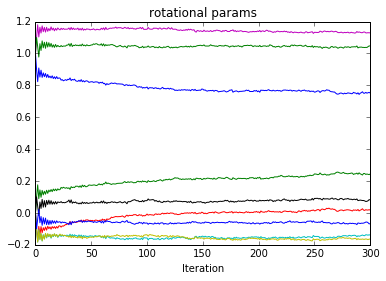

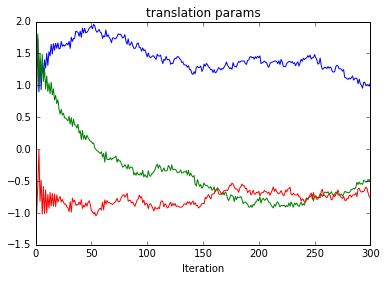

In [437]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
-0.669306667215 -0.669430579448
[[  7.64209569e-01   2.16241503e-01   9.88827510e-05   1.38018689e+00]
 [ -1.54801687e-01   1.13828874e+00  -1.65787052e-01  -8.30073926e-01]
 [  7.24395518e-02  -6.16445435e-02   1.04966111e+00  -5.73390578e-01]]


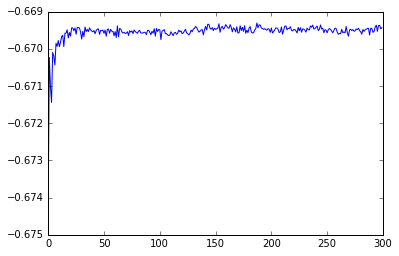

In [438]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [439]:
global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [440]:
G_movingvol2fixedvol = consolidate(params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)
print G_movingvol2fixedvol

[[  7.64209569e-01   2.16241503e-01   9.88827510e-05  -1.88836519e+01]
 [ -1.54801687e-01   1.13828874e+00  -1.65787052e-01  -9.44835160e+01]
 [  7.24395518e-02  -6.16445435e-02   1.04966111e+00  -2.48615153e+01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [441]:
def transform_volume_one_structure(structure):
    try:
        t = time.time()

#         vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32, prep_id=2, detector_id=detector_id)
        vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32,
                                                volume_type='score')

        volume_m_warped_inbbox, volume_m_warped_bbox_rel2movingvol = \
        transform_volume_v2(vol=vol_m, tf_params=G_movingvol2fixedvol[:3].flatten())
        
        # Note: volume_m_warped_bbox_rel2movingvol is the same as volume_m_warped_bbox_rel2fixedvol.
        volume_m_warped_bbox_rel2fixedvol = volume_m_warped_bbox_rel2movingvol
        
        ######### Save volume ##########
        
        volume_m_warped_fp = \
        DataManager.get_transformed_volume_filepath(stack_m=stack_moving,
                                                    stack_f=stack_fixed,
                                                    warp_setting=warp_setting,
                                                    vol_type_f='annotationAsScore',
                                                    structure=structure)

        create_parent_dir_if_not_exists(volume_m_warped_fp)
        bp.pack_ndarray_file(volume_m_warped_inbbox, volume_m_warped_fp)
        upload_to_s3(volume_m_warped_fp)
        
        ############### bbox #############
        volume_m_warped_bbox_fp = \
        DataManager.get_transformed_volume_bbox_filepath(stack_m=stack_moving,
                                                    stack_f=stack_fixed,
                                                    warp_setting=warp_setting,
                                                    vol_type_f='annotationAsScore',
                                                    structure=structure)

        create_parent_dir_if_not_exists(volume_m_warped_bbox_fp)
        np.savetxt(volume_m_warped_bbox_fp, volume_m_warped_bbox_rel2fixedvol)
        upload_to_s3(volume_m_warped_bbox_fp)
            
        sys.stderr.write('Transform: %.2f seconds.\n' % (time.time() - t)) # 3s
    
    except Exception as e:
        sys.stderr.write('Error transforming volume %s: %s.\n' % (structure, e))

In [442]:
# for s in all_known_structures_sided_with_surround:
for s in ['3N_L', 'RMC_L', 'SNR_L', '3N_L_surround_200', 'RMC_L_surround_200', 'SNR_L_surround_200']:
    transform_volume_one_structure(s)

Interpolating/filling sparse volume: 0.01 seconds.


aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_3N_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_3N_L.bp"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_3N_L_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_3N_L_bbox.txt"


Transform: 4.27 seconds.
Interpolating/filling sparse volume: 0.06 seconds.


aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_RMC_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_RMC_L.bp"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_RMC_L_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_RMC_L_bbox.txt"


Transform: 4.84 seconds.
Interpolating/filling sparse volume: 0.18 seconds.


aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_SNR_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_SNR_L.bp"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_SNR_L_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_SNR_L_bbox.txt"


Transform: 5.28 seconds.
Interpolating/filling sparse volume: 0.03 seconds.


aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_3N_L_surround_200.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_3N_L_surround_200.bp"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_3N_L_surround_200_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_3N_L_surround_200_bbox.txt"


Transform: 4.16 seconds.
Interpolating/filling sparse volume: 0.03 seconds.


aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_RMC_L_surround_200.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_RMC_L_surround_200.bp"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_RMC_L_surround_200_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_RMC_L_surround_200_bbox.txt"


Transform: 3.00 seconds.
Interpolating/filling sparse volume: 0.11 seconds.


aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_SNR_L_surround_200.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_SNR_L_surround_200.bp"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_SNR_L_surround_200_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_SNR_L_surround_200_bbox.txt"


Transform: 3.20 seconds.


In [443]:
structure = 'SNR_L'

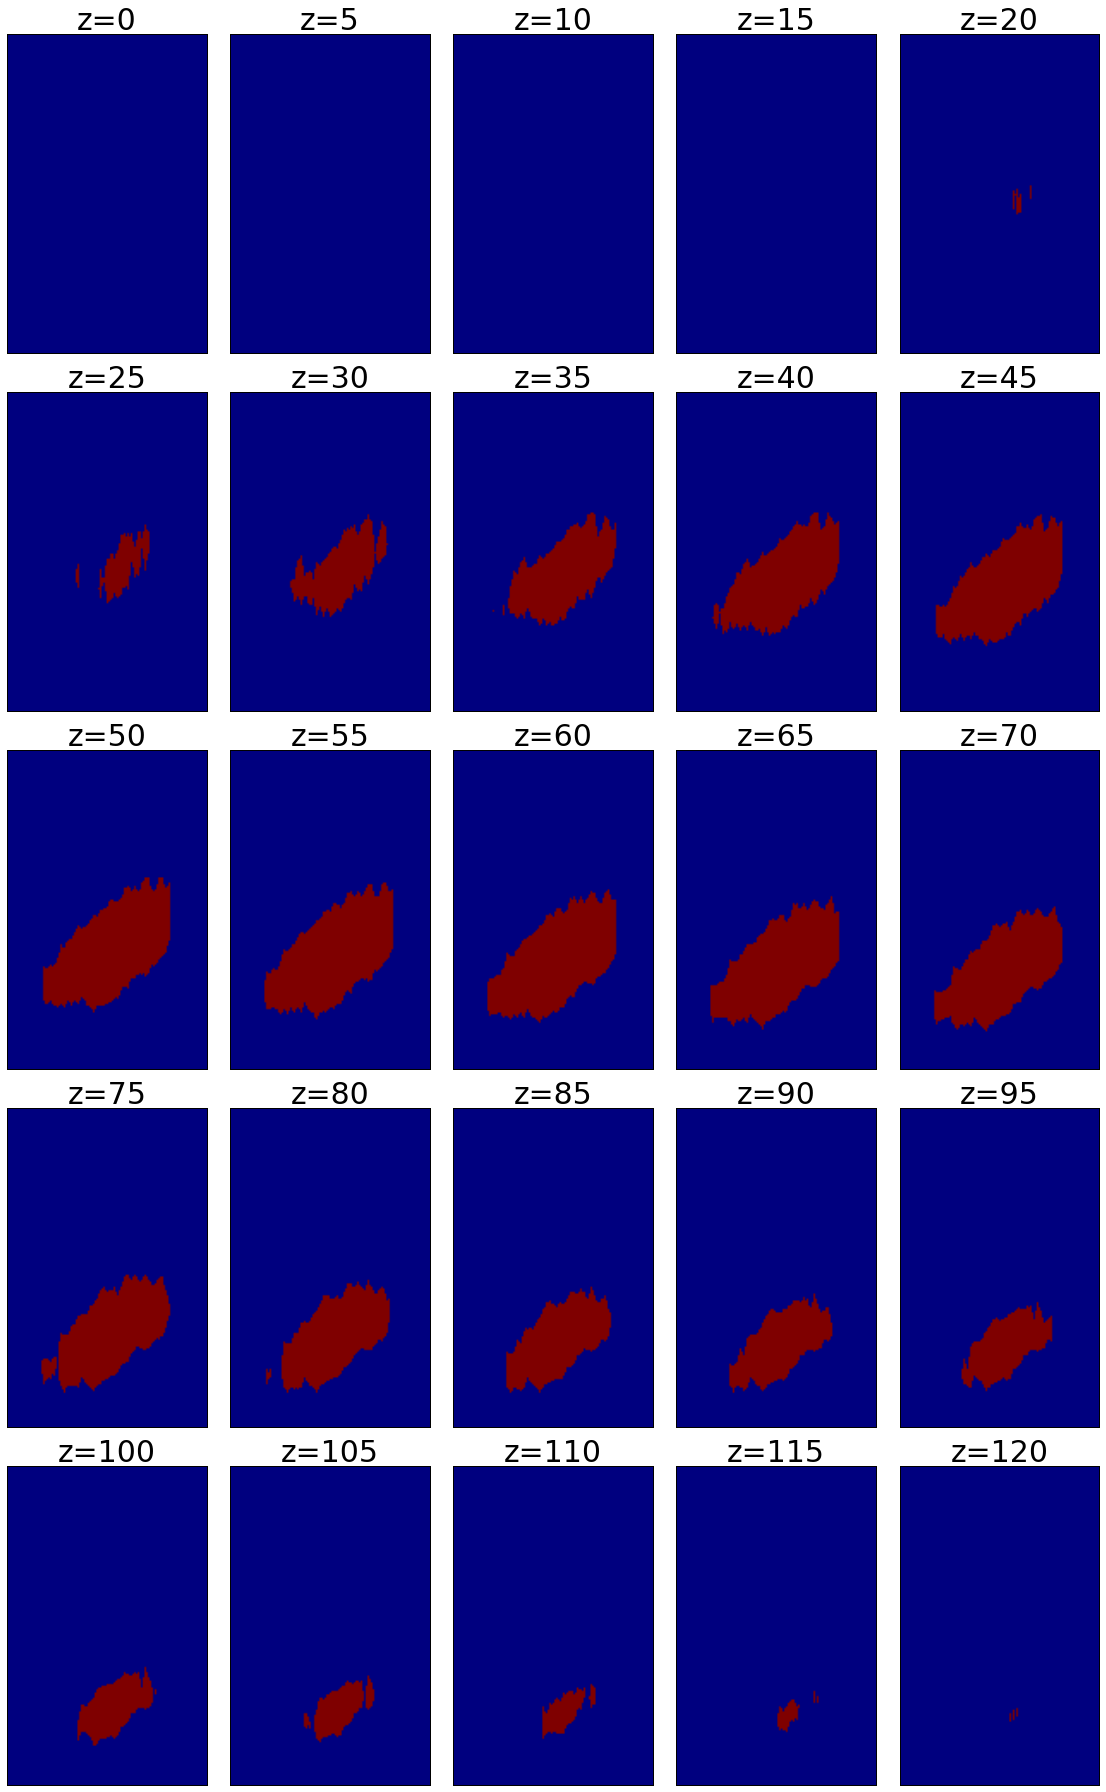

In [444]:
display_volume_sections(volume_fixed[structure_to_label_fixed[structure]], start_level=0)

In [445]:
# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving[structure_to_label_moving[structure]]

# volume_m2fg_in_bboxrel2fixedvol, volume_m2fg_bbox_rel2fixedvol = \
# transform_volume_v2(vol=vol_m, tf_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)
volume_m2fg_in_bboxrel2fixedvol, volume_m2fg_bbox_rel2fixedvol = \
transform_volume_v2(vol=vol_m, tf_params=G_movingvol2fixedvol[:3].flatten())

Interpolating/filling sparse volume: 0.08 seconds.


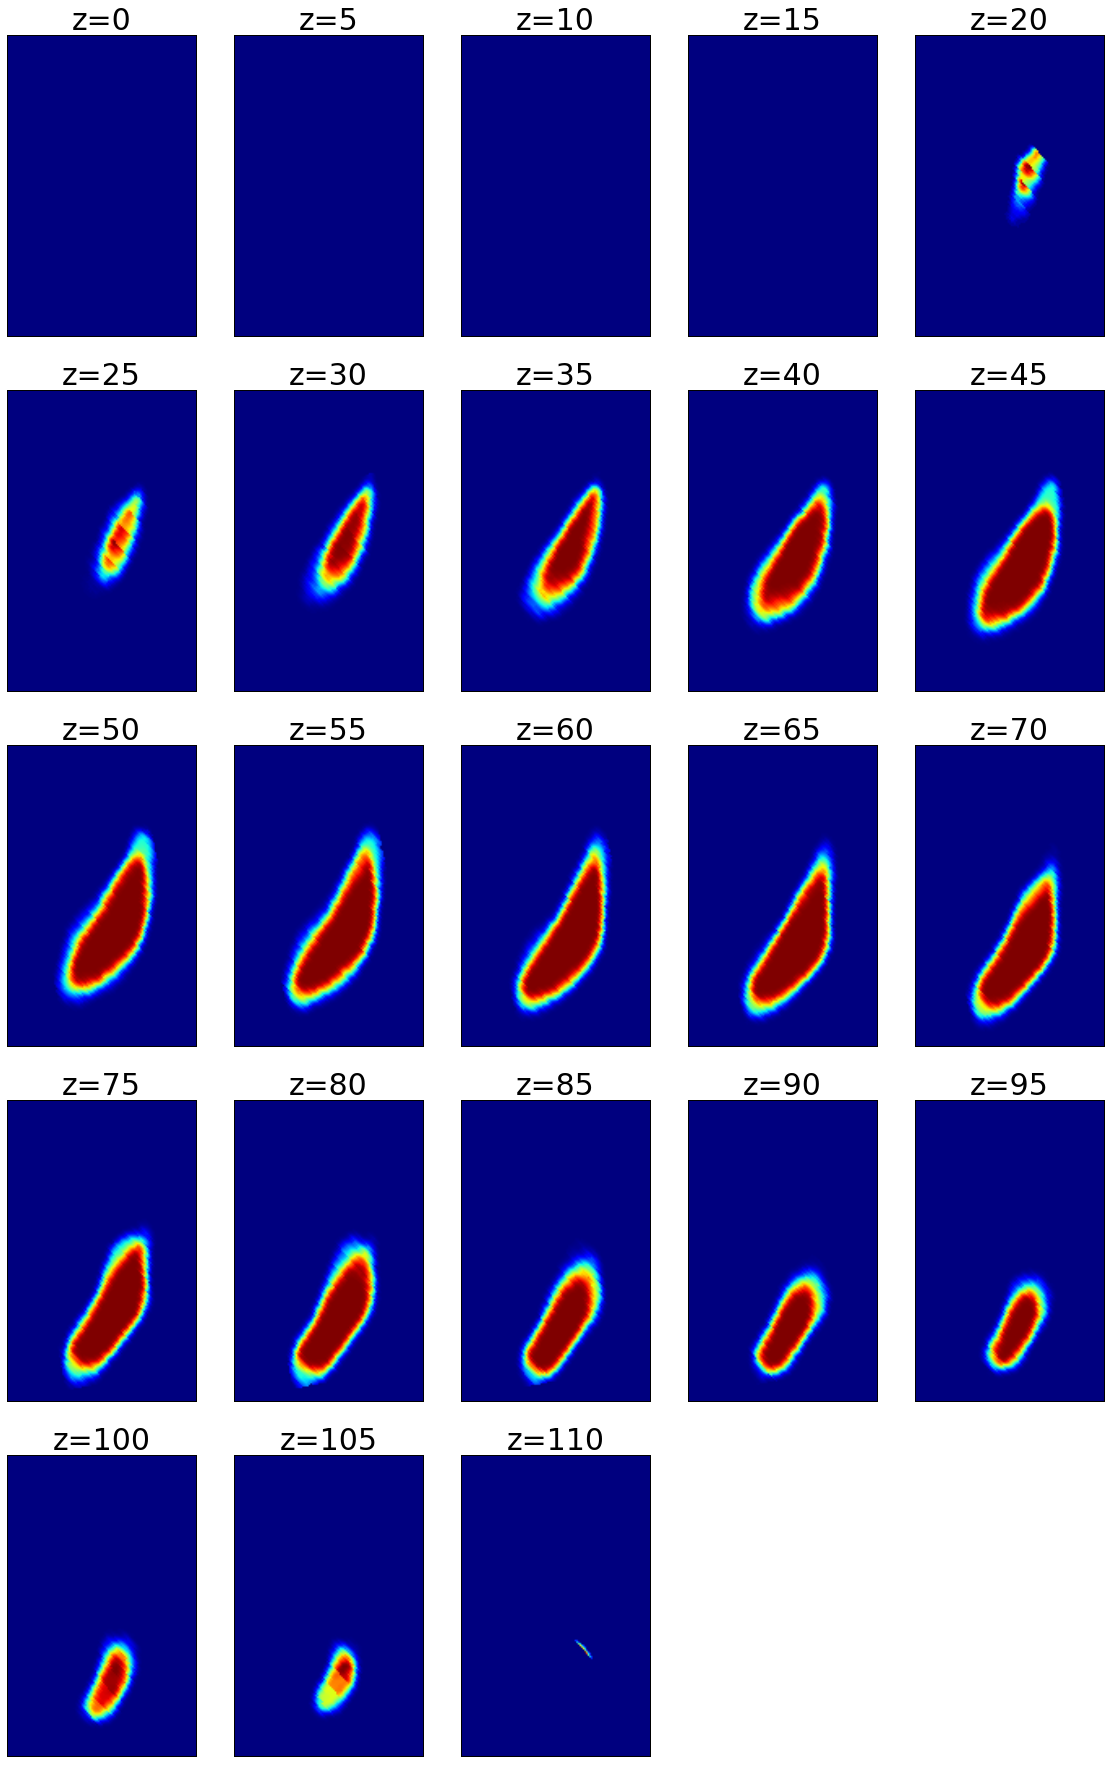

In [446]:
v_m2fg = \
crop_and_pad_volume(volume_m2fg_in_bboxrel2fixedvol, in_bbox=volume_m2fg_bbox_rel2fixedvol,
                    out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1))

display_volume_sections(v_m2fg, start_level=0)

In [447]:
# Warping all structures.

volume_m2fg = {}
for label_m, vol_m in volume_moving.iteritems():
    
#     volume_m2fg_in_bboxrel2fixedvol, volume_m2fg_bbox_rel2fixedvol = \
#         transform_volume_v2(vol=vol_m, tf_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)

    volume_m2fg_in_bboxrel2fixedvol, volume_m2fg_bbox_rel2fixedvol = \
        transform_volume_v2(vol=vol_m, tf_params=G_movingvol2fixedvol[:3].flatten())

    volume_m2fg[label_m] = crop_and_pad_volume(volume_m2fg_in_bboxrel2fixedvol, in_bbox=volume_m2fg_bbox_rel2fixedvol,
                    out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1))

Interpolating/filling sparse volume: 0.01 seconds.
Interpolating/filling sparse volume: 0.01 seconds.
Interpolating/filling sparse volume: 0.05 seconds.
Interpolating/filling sparse volume: 0.06 seconds.
Interpolating/filling sparse volume: 0.15 seconds.
Interpolating/filling sparse volume: 0.18 seconds.


# load markers

In [448]:
marker_xyzs_rel2fixedsubj = {}
m = bp.unpack_ndarray_file('/home/yuncong/lauren_data/markers/%(stack)s/%(stack)s_markers_SNR_L.bp' % \
                           {'stack':stack_fixed})
for marker_id, marker_xyz in enumerate(m):
    marker_xyzs_rel2fixedsubj[marker_id] = marker_xyz
    

fixedvol_bbox_rel2fixedsubj = DataManager.load_original_volume_bbox(stack=stack_fixed, structure='SNR_L', volume_type='annotationAsScore')

marker_xyzs_rel2fixedvol = {k: m - fixedvol_bbox_rel2fixedsubj[[0,2,4]]
                                for k, m in marker_xyzs_rel2fixedsubj.iteritems()}

# draw

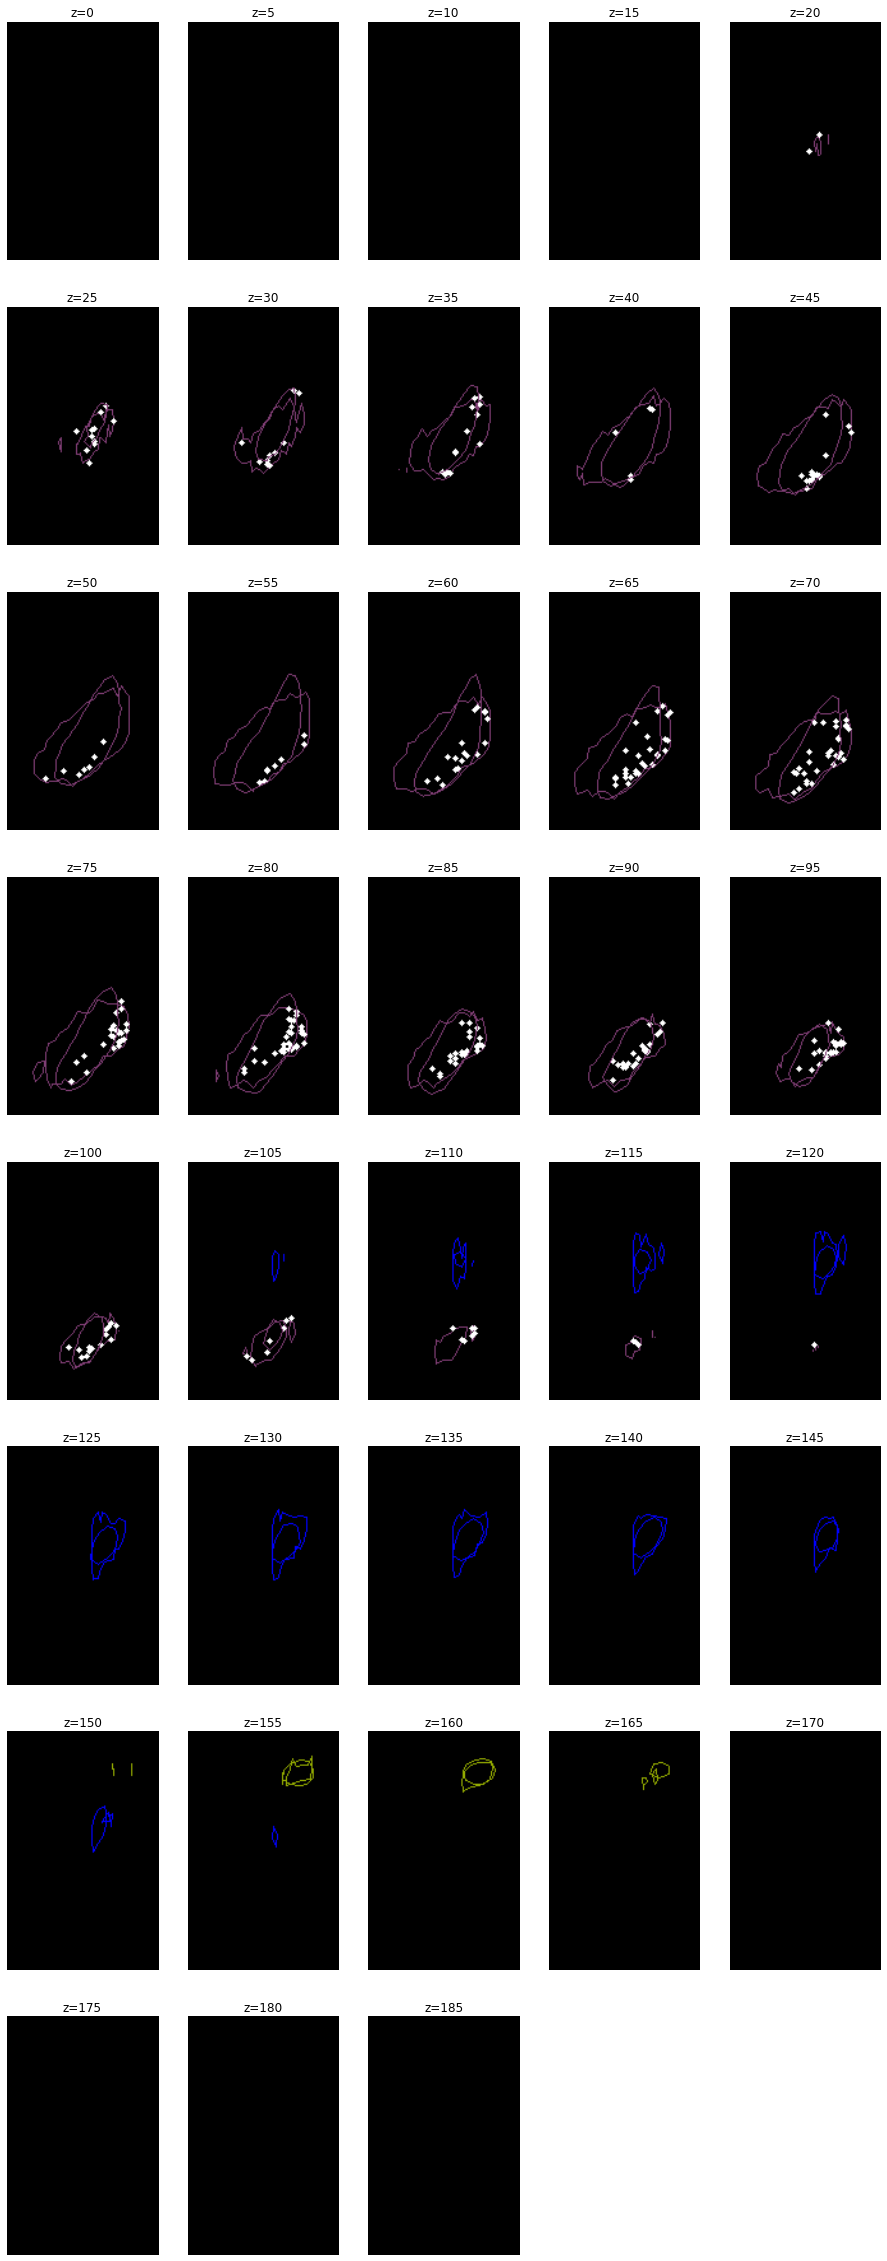

In [449]:
structures_to_draw = [l for l in volume_m2fg.keys() if not is_surround_label(label_to_structure_moving[l])]

colors = {l: name_unsided_to_color[convert_to_original_name(label_to_structure_fixed[l])]
for l in structures_to_draw}

draw_alignment(warped_atlas=volume_m2fg, fixed_volumes=volume_fixed, 
               zs=np.arange(0,volume_fixed.values()[0].shape[2],5), ncols=5,
              structures=structures_to_draw,
              colors=colors,
              markers=np.array(marker_xyzs_rel2fixedvol.values())
              )

In [450]:
#########################
# Save the best trial
#########################

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]

# Save parameters
params_fp = \
    DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  warp_setting=warp_setting,
                                              vol_type_f='annotationAsScore',
                                                 what='parameters')
DataManager.save_alignment_parameters(params_fp, T_all_trials[best_trial], 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
upload_to_s3(params_fp)

# Save score history
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              warp_setting=warp_setting,
                                                       vol_type_f='annotationAsScore',
                                             what='scoreHistory')
bp.pack_ndarray_file(np.array(scores_all_trials[best_trial]), history_fp)
upload_to_s3(history_fp)

# Save score plot
score_plot_fp = \
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              warp_setting=warp_setting,
                                                       vol_type_f='annotationAsScore',
                                             what='scoreEvolution')
fig = plt.figure();
plt.plot(scores_all_trials[best_trial]);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)
upload_to_s3(score_plot_fp)

# Save trajectory
trajectory_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  warp_setting=warp_setting,
                                                          vol_type_f='annotationAsScore',
                                                 what='trajectory')
bp.pack_ndarray_file(np.array(traj_all_trials[best_trial]), trajectory_fp)
upload_to_s3(trajectory_fp)

aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_parameters.txt" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_parameters.txt"
aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsScoreVolume_scoreHistory.bp"
aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM72_down32_annotationAsSc

# Local

warp setting = 16 means directly rigidly register SNR_L with atlas SNR_L, taking surround into consideration.

In [4]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment,max_iter_num
warp_id,,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000.0,2000.0,2000.0,30.0,0,NaN,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,10.0,0,0.000001,NaN,NaN
5,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,30.0,inverse,0.000000,NaN,NaN
6,1,affine,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,-0.5,0.000000,NaN,NaN
7,None,rigid,0.000001,100000.0,1000.0,50.0,50.0,50.0,10.0,0,NaN,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200.0,200.0,200.0,30.0,NaN,0.000000,align mid-sagittal planes,NaN
9,8,rigid,0.000001,100000.0,10000.0,2000.0,2000.0,2000.0,30.0,NaN,NaN,global registration given mid-sagittal planes ...,NaN
10,None,rigid,0.000010,100000.0,1000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN


In [452]:
# # stack_fixed = 'LM30'
# # stack_fixed = 'LM30new'
# # stack_fixed = 'LM40'
# # stack_fixed = 'LM40new'
# # stack_fixed = 'LM31'
# # stack_fixed = 'LM38'
# # stack_fixed = 'LM48'

# stack_fixed = 'LM42_LM37'
# # stack_fixed = 'LM46'
# # stack_fixed = 'LM22'
# # stack_fixed = 'LM41'
# # stack_fixed = 'LM86'
# # stack_fixed = 'LM84'
# # stack_fixed = 'LM32'
# # stack_fixed = 'LM72'

# stack_moving = 'atlasV5'

In [15]:
stack_m_spec = dict(name='atlasV5',
                   vol_type='score',
                   detector_id=None,
                   prep_id=None,
                   structure=structure_m,
                    resolution='10.0um'
                   )

stack_f_spec = dict(name='MD589',
                   vol_type='score',
                   detector_id=998,
                   prep_id=None,
                   structure=convert_to_original_name(structure_m),
                    resolution='10.0um'
                   )

local_alignment_spec = dict(stack_m=stack_m_spec, 
                      stack_f=stack_f_spec,
                      warp_setting=27)

In [453]:
warp_setting = 25

In [454]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
else:
    upstream_warp_setting = int(upstream_warp_setting)
    
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])

try:
    surround_weight = float(warp_properties['surround_weight'])
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
except:
    surround_weight = str(warp_properties['surround_weight'])
    include_surround = True

reg_weight = warp_properties['regularization_weight']
if np.isnan(reg_weight):
    reg_weights = np.zeros((3,))
else:
    reg_weights = np.ones((3,))*reg_weight

print
print 'std', std_tx, std_ty, std_tz, std_theta_xy
print 'surround', surround_weight
print 'regularization', reg_weights

upstream_warp_id                                                                 24
transform_type                                                                rigid
terminate_thresh                                                                NaN
grad_computation_sample_number                                                10000
grid_search_sample_number                                                       NaN
std_tx_um                                                                       NaN
std_ty_um                                                                       NaN
std_tz_um                                                                       NaN
std_theta_xy_degree                                                             NaN
surround_weight                                                             inverse
regularization_weight                                                             0
comment                           local reg with surr no grid search; global

In [455]:
MAX_ITER_NUM = 10000
HISTORY_LEN = 200
# MAX_GRID_SEARCH_ITER_NUM = 30

In [456]:
lr1 = 10
lr2 = 0.1

In [457]:
structure = 'SNR_L'

In [458]:
if include_surround:
    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                structures=[structure, convert_to_surround_name(structure, margin='200')], volume_type='annotationAsScore')
else:
    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                                                 structures=[structure], volume_type='annotationAsScore')
# This loads the internal/inside-bbox volume.
# So registration is done with respect to this.
# Need to take into account the actual bbox when converting points.

Prior structure/index map not found. Generating a new one.
Volume shape: (187, 117, 188)


In [459]:
print DataManager.load_original_volume_bbox(stack=stack_fixed, structure='SNR_L', volume_type='annotationAsScore')

[ -17   99 -578 -392 2450 2637]


In [460]:
# if include_surround:
#     volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
#                                 structures=[structure, convert_to_surround_name(structure, margin='200')])
# else:
#     volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
#                                                                  structures=[structure])

if include_surround:
    structures = [structure, convert_to_surround_name(structure, margin='200')]
else:
    structures = [structure]
    
volume_moving_in_bboxrel2fixedvol, volume_moving_bbox_rel2fixedvol, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_transformed_volume_all_known_structures_v2(stack_m=stack_moving, 
                                                         stack_f=stack_fixed,
                                                         warp_setting=24,
                                                         vol_type_f='annotationAsScore',
                                                         vol_type_m='score',
                            structures=[structure, convert_to_surround_name(structure, margin='200')],
                                                        return_label_mappings=True,
                                                         name_or_index_as_key='index',                                                               
                                                            common_shape=True)

print volume_moving_bbox_rel2fixedvol

[  26.   99.   45.  187.    9.  121.]


Prior structure/index map not found. Generating a new one.


In [461]:
# structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
# label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
# volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()}

cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving_in_bboxrel2fixedvol.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving_in_bboxrel2fixedvol[l] > cutoff), 
                                                  volume_moving_in_bboxrel2fixedvol.keys())))
pool.close()
pool.join()


positive_weight = 'size'
# positive_weight = 'inverse'

label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
            # Note that this is positive; in regular, surround is negative
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

In [462]:
label_weights_m

{1: 1.0, 2: 0.4048361676898368}

In [463]:
aligner = Aligner4(volume_fixed, volume_moving_in_bboxrel2fixedvol, 
                   labelIndexMap_m2f=label_mapping_m2f)

aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving[structure]])

aligner.set_regularization_weights(reg_weights)
aligner.set_label_weights(label_weights_m)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [ 38.21489794  74.19606771  52.70878951], centroid_f: [  61.11993345  123.25224512   62.86939723]


In [464]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [465]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s = 2 mins

indices_f: set([1, 2])
load gradient 1: 0.078432 seconds
load gradient 2: 0.081602 seconds
overall: 0.160189 seconds


In [466]:
trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for trial_idx in range(trial_num):

    T, scores = aligner.optimize(tf_type=transform_type, 
                                 max_iter_num=MAX_ITER_NUM, 
                                 history_len=HISTORY_LEN, 
#                                  grad_computation_sample_number=int(grad_computation_sample_number),
                                 lr1=1, lr2=1e-2, 
                                 terminate_thresh_trans=0.5, terminate_thresh_rot=0.001)
#                                  init_T=grid_search_T)

#         print T.reshape((3,4))
#         plt.figure();
#         plt.plot(scores);
#         plt.show();
#         print max(scores), scores[-1]

    T_all_trials.append(T)
    scores_all_trials.append(scores)
    traj_all_trials.append(np.array(aligner.Ts))


iteration 0
Norm of gradient = 2.449490
around x=0.57; around y=-0.58; around z=0.57
step: 0.30 seconds
current score: 0.194707
new_T: [-0.99993333 -1.00996642  0.98996692]
det: 1.00

iteration 1
Norm of gradient = 1.752382
around x=0.58; around y=-0.01; around z=0.84
step: 0.31 seconds
current score: 0.198248
new_T: [-0.01140809 -0.93921415  0.05383692]
det: 1.00

iteration 2
Norm of gradient = 1.015813
around x=0.87; around y=0.17; around z=1.19
step: 0.30 seconds
current score: 0.199558
new_T: [ 0.37055536 -1.3506824  -0.00802464]
det: 1.00

iteration 3
Norm of gradient = 0.908673
around x=1.10; around y=0.38; around z=1.46
step: 0.30 seconds
current score: 0.201202
new_T: [ 0.8324476 -1.6139478 -0.0878339]
det: 1.00

iteration 4
Norm of gradient = 0.831110
around x=1.32; around y=0.56; around z=1.75
step: 0.31 seconds
current score: 0.202626
new_T: [ 1.15797797 -1.90305075 -0.21099872]
det: 1.00

iteration 5
Norm of gradient = 0.745750
around x=1.53; around y=0.70; around z=2.02
s

Norm of gradient = 0.200364
around x=4.93; around y=3.75; around z=7.61
step: 0.30 seconds
current score: 0.220382
new_T: [ 2.34471384 -1.95075458 -0.57189023]
det: 1.00

iteration 46
Norm of gradient = 0.196359
around x=4.98; around y=3.81; around z=7.69
step: 0.30 seconds
current score: 0.220540
new_T: [ 2.32351949 -1.92115203 -0.55883713]
det: 1.00

iteration 47
Norm of gradient = 0.193184
around x=5.04; around y=3.87; around z=7.77
step: 0.23 seconds
current score: 0.220735
new_T: [ 2.31076737 -1.90233963 -0.53846106]
det: 1.00

iteration 48
Norm of gradient = 0.191735
around x=5.09; around y=3.93; around z=7.84
step: 0.20 seconds
current score: 0.220907
new_T: [ 2.30730102 -1.88278169 -0.51591002]
det: 1.00

iteration 49
Norm of gradient = 0.191418
around x=5.14; around y=4.00; around z=7.91
step: 0.21 seconds
current score: 0.221061
new_T: [ 2.3154702  -1.86018299 -0.5251657 ]
det: 1.00

iteration 50
Norm of gradient = 0.186766
around x=5.20; around y=4.06; around z=7.99
step: 0.

Norm of gradient = 0.119811
around x=6.71; around y=6.19; around z=10.20
step: 0.21 seconds
current score: 0.225365
new_T: [ 1.89847307 -1.17863181 -0.18835024]
det: 1.00

iteration 91
Norm of gradient = 0.116005
around x=6.73; around y=6.24; around z=10.25
step: 0.21 seconds
current score: 0.225433
new_T: [ 1.88979117 -1.16699433 -0.1727894 ]
det: 1.00

iteration 92
Norm of gradient = 0.116239
around x=6.76; around y=6.28; around z=10.29
step: 0.20 seconds
current score: 0.225506
new_T: [ 1.88575419 -1.1474906  -0.17408589]
det: 1.00

iteration 93
Norm of gradient = 0.112715
around x=6.79; around y=6.32; around z=10.33
step: 0.20 seconds
current score: 0.225578
new_T: [ 1.87947201 -1.1470336  -0.14883483]
det: 1.00

iteration 94
Norm of gradient = 0.116021
around x=6.81; around y=6.37; around z=10.37
step: 0.21 seconds
current score: 0.225630
new_T: [ 1.88797613 -1.13743106 -0.16378977]
det: 1.00

iteration 95
Norm of gradient = 0.110416
around x=6.84; around y=6.41; around z=10.41
st

Norm of gradient = 0.076767
around x=7.53; around y=7.97; around z=11.76
step: 0.18 seconds
current score: 0.227368
new_T: [ 1.69555639 -0.85031666  0.00930676]
det: 1.00

iteration 137
Norm of gradient = 0.076359
around x=7.54; around y=8.00; around z=11.79
step: 0.21 seconds
current score: 0.227382
new_T: [  1.69223495e+00  -8.44459039e-01   1.42275524e-03]
det: 1.00

iteration 138
Norm of gradient = 0.073196
around x=7.55; around y=8.04; around z=11.81
step: 0.30 seconds
current score: 0.227401
new_T: [  1.68815236e+00  -8.45751397e-01   6.98167131e-04]
det: 1.00

iteration 139
Norm of gradient = 0.074442
around x=7.56; around y=8.07; around z=11.84
step: 0.30 seconds
current score: 0.227429
new_T: [  1.69038010e+00  -8.43840261e-01   2.34729267e-04]
det: 1.00

iteration 140
Norm of gradient = 0.074683
around x=7.57; around y=8.10; around z=11.87
step: 0.30 seconds
current score: 0.227462
new_T: [ 1.69017908 -0.84315707 -0.00684954]
det: 1.00

iteration 141
Norm of gradient = 0.0727

Norm of gradient = 0.054774
around x=7.83; around y=9.15; around z=12.79
step: 0.30 seconds
current score: 0.228289
new_T: [ 1.57729445 -0.75139155  0.11820047]
det: 1.00

iteration 181
Norm of gradient = 0.052528
around x=7.84; around y=9.17; around z=12.81
step: 0.30 seconds
current score: 0.228309
new_T: [ 1.57759887 -0.75220579  0.12389304]
det: 1.00

iteration 182
Norm of gradient = 0.052255
around x=7.84; around y=9.20; around z=12.83
step: 0.30 seconds
current score: 0.228319
new_T: [ 1.57284775 -0.75169374  0.1244911 ]
det: 1.00

iteration 183
Norm of gradient = 0.052165
around x=7.84; around y=9.22; around z=12.85
step: 0.30 seconds
current score: 0.228316
new_T: [ 1.57254696 -0.7445984   0.12403068]
det: 1.00

iteration 184
Norm of gradient = 0.051947
around x=7.85; around y=9.24; around z=12.87
step: 0.28 seconds
current score: 0.228335
new_T: [ 1.56416335 -0.74837852  0.14346265]
det: 1.00

iteration 185
Norm of gradient = 0.053810
around x=7.85; around y=9.26; around z=12.

Norm of gradient = 0.039058
around x=7.89; around y=10.02; around z=13.58
step: 0.43 seconds
current score: 0.228852
new_T: [ 1.45720594 -0.71296301  0.17292857]
det: 1.00

iteration 226
Norm of gradient = 0.039183
around x=7.89; around y=10.04; around z=13.60
step: 0.45 seconds
current score: 0.228866
new_T: [ 1.45582324 -0.71012808  0.17400281]
det: 1.00

iteration 227
Norm of gradient = 0.038713
around x=7.89; around y=10.05; around z=13.61
step: 0.44 seconds
current score: 0.228879
new_T: [ 1.45640723 -0.70917949  0.18045706]
det: 1.00

iteration 228
Norm of gradient = 0.038356
around x=7.89; around y=10.07; around z=13.63
step: 0.45 seconds
current score: 0.228890
new_T: [ 1.45618577 -0.70815349  0.19118596]
det: 1.00

iteration 229
Norm of gradient = 0.038214
around x=7.89; around y=10.08; around z=13.64
step: 0.39 seconds
current score: 0.228889
new_T: [ 1.45306806 -0.70817389  0.18979863]
det: 1.00

iteration 230
Norm of gradient = 0.038208
around x=7.89; around y=10.10; around

Norm of gradient = 0.031107
around x=7.84; around y=10.64; around z=14.21
step: 0.20 seconds
current score: 0.229221
new_T: [ 1.4069081  -0.70870627  0.21190078]
det: 1.00

iteration 271
Norm of gradient = 0.031366
around x=7.84; around y=10.65; around z=14.22
step: 0.18 seconds
current score: 0.229228
new_T: [ 1.40940208 -0.7099139   0.21089932]
det: 1.00

iteration 272
Norm of gradient = 0.033296
around x=7.84; around y=10.66; around z=14.23
step: 0.19 seconds
current score: 0.229242
new_T: [ 1.4110034  -0.71098792  0.20232476]
det: 1.00

iteration 273
Norm of gradient = 0.030225
around x=7.84; around y=10.67; around z=14.24
step: 0.19 seconds
current score: 0.229248
new_T: [ 1.40760491 -0.71497707  0.20853935]
det: 1.00

iteration 274
Norm of gradient = 0.031170
around x=7.83; around y=10.69; around z=14.25
step: 0.35 seconds
current score: 0.229241
new_T: [ 1.40919825 -0.71783424  0.2039547 ]
det: 1.00

iteration 275
Norm of gradient = 0.029862
around x=7.83; around y=10.70; around

Norm of gradient = 0.025282
around x=7.73; around y=11.06; around z=14.71
step: 0.30 seconds
current score: 0.229448
new_T: [ 1.3982664  -0.72186822  0.23940851]
det: 1.00

iteration 315
Norm of gradient = 0.029392
around x=7.72; around y=11.07; around z=14.72
step: 0.30 seconds
current score: 0.229457
new_T: [ 1.40225599 -0.72161836  0.22683542]
det: 1.00

iteration 316
Norm of gradient = 0.025186
around x=7.72; around y=11.08; around z=14.73
step: 0.30 seconds
current score: 0.229466
new_T: [ 1.39452011 -0.72654984  0.23160075]
det: 1.00

iteration 317
Norm of gradient = 0.024680
around x=7.72; around y=11.09; around z=14.74
step: 0.30 seconds
current score: 0.229464
new_T: [ 1.39821061 -0.72946492  0.23192663]
det: 1.00

iteration 318
Norm of gradient = 0.024693
around x=7.72; around y=11.10; around z=14.75
step: 0.29 seconds
current score: 0.229467
new_T: [ 1.39457909 -0.73413388  0.23229627]
det: 1.00

iteration 319
Norm of gradient = 0.026134
around x=7.71; around y=11.11; around

Norm of gradient = 0.023120
around x=7.59; around y=11.42; around z=15.14
step: 0.16 seconds
current score: 0.229613
new_T: [ 1.29031971 -0.73904956  0.21071965]
det: 1.00

iteration 360
Norm of gradient = 0.022242
around x=7.59; around y=11.42; around z=15.15
step: 0.16 seconds
current score: 0.229614
new_T: [ 1.29198904 -0.73881009  0.22021154]
det: 1.00

iteration 361
Norm of gradient = 0.026849
around x=7.58; around y=11.43; around z=15.16
step: 0.16 seconds
current score: 0.229624
new_T: [ 1.29338242 -0.73636116  0.20751725]
det: 1.00

iteration 362
Norm of gradient = 0.022052
around x=7.58; around y=11.44; around z=15.17
step: 0.16 seconds
current score: 0.229626
new_T: [ 1.28796376 -0.74065583  0.21550779]
det: 1.00

iteration 363
Norm of gradient = 0.023014
around x=7.58; around y=11.45; around z=15.18
step: 0.16 seconds
current score: 0.229628
new_T: [ 1.29098762 -0.73807898  0.2112468 ]
det: 1.00

iteration 364
Norm of gradient = 0.021161
around x=7.57; around y=11.45; around

Norm of gradient = 0.017502
around x=7.47; around y=11.68; around z=15.50
step: 0.31 seconds
current score: 0.229719
new_T: [ 1.26333281 -0.76614555  0.20880331]
det: 1.00

iteration 404
Norm of gradient = 0.017117
around x=7.46; around y=11.69; around z=15.51
step: 0.30 seconds
current score: 0.229719
new_T: [ 1.26414104 -0.76724084  0.20833847]
det: 1.00

iteration 405
Norm of gradient = 0.017011
around x=7.46; around y=11.69; around z=15.52
step: 0.30 seconds
current score: 0.229723
new_T: [ 1.26239841 -0.76750574  0.208969  ]
det: 1.00

iteration 406
Norm of gradient = 0.018983
around x=7.45; around y=11.70; around z=15.52
step: 0.31 seconds
current score: 0.229726
new_T: [ 1.2618124  -0.76592036  0.20296738]
det: 1.00

iteration 407
Norm of gradient = 0.017756
around x=7.45; around y=11.70; around z=15.53
step: 0.30 seconds
current score: 0.229735
new_T: [ 1.26391048 -0.7656048   0.19893457]
det: 1.00

iteration 408
Norm of gradient = 0.016340
around x=7.45; around y=11.71; around

Norm of gradient = 0.016481
around x=7.32; around y=11.86; around z=15.81
step: 0.30 seconds
current score: 0.229861
new_T: [ 1.23580605 -0.77311494  0.19871729]
det: 1.00

iteration 448
Norm of gradient = 0.016304
around x=7.32; around y=11.86; around z=15.82
step: 0.30 seconds
current score: 0.229862
new_T: [ 1.23225641 -0.77219273  0.19790625]
det: 1.00

iteration 449
Norm of gradient = 0.015697
around x=7.32; around y=11.86; around z=15.82
step: 0.30 seconds
current score: 0.229864
new_T: [ 1.22960465 -0.77393152  0.20352519]
det: 1.00

iteration 450
Norm of gradient = 0.017198
around x=7.31; around y=11.87; around z=15.83
step: 0.30 seconds
current score: 0.229865
new_T: [ 1.23552982 -0.77060892  0.20319628]
det: 1.00

iteration 451
Norm of gradient = 0.015575
around x=7.31; around y=11.87; around z=15.84
step: 0.34 seconds
current score: 0.229867
new_T: [ 1.23191847 -0.77489203  0.20643343]
det: 1.00

iteration 452
Norm of gradient = 0.017066
around x=7.31; around y=11.88; around

Norm of gradient = 0.015024
around x=7.20; around y=12.05; around z=16.06
step: 0.18 seconds
current score: 0.229884
new_T: [ 1.22167092 -0.7855894   0.206795  ]
det: 1.00

iteration 492
Norm of gradient = 0.014988
around x=7.20; around y=12.06; around z=16.07
step: 0.18 seconds
current score: 0.229888
new_T: [ 1.22117979 -0.78342707  0.20256427]
det: 1.00

iteration 493
Norm of gradient = 0.013623
around x=7.20; around y=12.06; around z=16.07
step: 0.18 seconds
current score: 0.229884
new_T: [ 1.21679765 -0.78422691  0.20517758]
det: 1.00

iteration 494
Norm of gradient = 0.012811
around x=7.20; around y=12.06; around z=16.08
step: 0.18 seconds
current score: 0.229884
new_T: [ 1.21507966 -0.78538942  0.20591012]
det: 1.00

iteration 495
Norm of gradient = 0.012929
around x=7.19; around y=12.07; around z=16.09
step: 0.18 seconds
current score: 0.229887
new_T: [ 1.2143142  -0.78820228  0.21005326]
det: 1.00

iteration 496
Norm of gradient = 0.013853
around x=7.19; around y=12.07; around

Norm of gradient = 0.012047
around x=7.10; around y=12.20; around z=16.29
step: 0.18 seconds
current score: 0.229950
new_T: [ 1.21502569 -0.80485931  0.20015885]
det: 1.00

iteration 536
Norm of gradient = 0.012137
around x=7.09; around y=12.21; around z=16.29
step: 0.18 seconds
current score: 0.229944
new_T: [ 1.21289511 -0.80616718  0.19730852]
det: 1.00

iteration 537
Norm of gradient = 0.011494
around x=7.09; around y=12.21; around z=16.30
step: 0.18 seconds
current score: 0.229946
new_T: [ 1.21540394 -0.80739443  0.19831888]
det: 1.00

iteration 538
Norm of gradient = 0.011724
around x=7.09; around y=12.21; around z=16.30
step: 0.18 seconds
current score: 0.229943
new_T: [ 1.21451455 -0.80741645  0.19688493]
det: 1.00

iteration 539
Norm of gradient = 0.012230
around x=7.09; around y=12.22; around z=16.30
step: 0.18 seconds
current score: 0.229942
new_T: [ 1.21685346 -0.8086749   0.19392398]
det: 1.00

iteration 540
Norm of gradient = 0.013721
around x=7.08; around y=12.22; around

Norm of gradient = 0.010908
around x=7.00; around y=12.33; around z=16.47
step: 0.18 seconds
current score: 0.229981
new_T: [ 1.20711844 -0.8116973   0.18086626]
det: 1.00

iteration 580
Norm of gradient = 0.011870
around x=7.00; around y=12.33; around z=16.48
step: 0.18 seconds
current score: 0.229982
new_T: [ 1.20158413 -0.81126948  0.17838852]
det: 1.00

iteration 581
Norm of gradient = 0.010275
around x=6.99; around y=12.33; around z=16.48
step: 0.18 seconds
current score: 0.229986
new_T: [ 1.19937901 -0.80921509  0.17793374]
det: 1.00

iteration 582
Norm of gradient = 0.010393
around x=6.99; around y=12.34; around z=16.49
step: 0.19 seconds
current score: 0.229984
new_T: [ 1.19721789 -0.8069284   0.17757349]
det: 1.00

iteration 583
Norm of gradient = 0.012128
around x=6.99; around y=12.34; around z=16.49
step: 0.19 seconds
current score: 0.229982
new_T: [ 1.19068024 -0.80527835  0.1779671 ]
det: 1.00

iteration 584
Norm of gradient = 0.009822
around x=6.99; around y=12.34; around

Norm of gradient = 0.010295
around x=6.89; around y=12.39; around z=16.65
step: 0.18 seconds
current score: 0.230019
new_T: [ 1.16693931 -0.7696232   0.19002485]
det: 1.00

iteration 624
Norm of gradient = 0.009903
around x=6.89; around y=12.39; around z=16.65
step: 0.18 seconds
current score: 0.230018
new_T: [ 1.16229632 -0.76997667  0.18920026]
det: 1.00

iteration 625
Norm of gradient = 0.009015
around x=6.89; around y=12.39; around z=16.65
step: 0.18 seconds
current score: 0.230018
new_T: [ 1.15896694 -0.77038485  0.18892873]
det: 1.00

iteration 626
Norm of gradient = 0.007972
around x=6.89; around y=12.39; around z=16.66
step: 0.18 seconds
current score: 0.230015
new_T: [ 1.15811392 -0.77219238  0.18935157]
det: 1.00

iteration 627
Norm of gradient = 0.008636
around x=6.88; around y=12.39; around z=16.66
step: 0.18 seconds
current score: 0.230012
new_T: [ 1.15692108 -0.77284911  0.18705049]
det: 1.00

iteration 628
Norm of gradient = 0.007870
around x=6.88; around y=12.40; around

Norm of gradient = 0.009081
around x=6.79; around y=12.46; around z=16.78
step: 0.31 seconds
current score: 0.230016
new_T: [ 1.13142832 -0.79283872  0.16037623]
det: 1.00

iteration 668
Norm of gradient = 0.010572
around x=6.79; around y=12.46; around z=16.78
step: 0.28 seconds
current score: 0.230015
new_T: [ 1.13182098 -0.78985916  0.15549443]
det: 1.00

iteration 669
Norm of gradient = 0.008197
around x=6.79; around y=12.46; around z=16.78
step: 0.20 seconds
current score: 0.230020
new_T: [ 1.1330149  -0.79040874  0.1531549 ]
det: 1.00

iteration 670
Norm of gradient = 0.007673
around x=6.78; around y=12.46; around z=16.78
step: 0.18 seconds
current score: 0.230026
new_T: [ 1.13210127 -0.79179128  0.15486896]
det: 1.00

iteration 671
Norm of gradient = 0.009318
around x=6.78; around y=12.46; around z=16.79
step: 0.19 seconds
current score: 0.230022
new_T: [ 1.12989679 -0.79124673  0.15182154]
det: 1.00

iteration 672
Norm of gradient = 0.009360
around x=6.78; around y=12.46; around

Norm of gradient = 0.007394
around x=6.70; around y=12.51; around z=16.90
step: 0.37 seconds
current score: 0.230041
new_T: [ 1.13112529 -0.8105679   0.14961607]
det: 1.00

iteration 712
Norm of gradient = 0.007311
around x=6.70; around y=12.52; around z=16.91
step: 0.39 seconds
current score: 0.230042
new_T: [ 1.13189292 -0.80881445  0.14841227]
det: 1.00

iteration 713
Norm of gradient = 0.007492
around x=6.70; around y=12.52; around z=16.91
step: 0.36 seconds
current score: 0.230048
new_T: [ 1.13179508 -0.80731533  0.14641434]
det: 1.00

iteration 714
Norm of gradient = 0.006463
around x=6.69; around y=12.52; around z=16.91
step: 0.36 seconds
current score: 0.230045
new_T: [ 1.13155882 -0.80829581  0.14847246]
det: 1.00

iteration 715
Norm of gradient = 0.008785
around x=6.69; around y=12.52; around z=16.91
step: 0.38 seconds
current score: 0.230049
new_T: [ 1.12628665 -0.81001533  0.15078042]
det: 1.00

iteration 716
Norm of gradient = 0.006501
around x=6.69; around y=12.52; around

Norm of gradient = 0.007184
around x=6.62; around y=12.55; around z=17.02
step: 0.23 seconds
current score: 0.230049
new_T: [ 1.06295716 -0.79819685  0.12458477]
det: 1.00

iteration 756
Norm of gradient = 0.006919
around x=6.62; around y=12.55; around z=17.02
step: 0.30 seconds
current score: 0.230046
new_T: [ 1.06451533 -0.79734712  0.12533756]
det: 1.00

iteration 757
Norm of gradient = 0.006952
around x=6.61; around y=12.55; around z=17.02
step: 0.29 seconds
current score: 0.230050
new_T: [ 1.06388744 -0.79688135  0.12508436]
det: 1.00

iteration 758
Norm of gradient = 0.008095
around x=6.61; around y=12.55; around z=17.03
step: 0.29 seconds
current score: 0.230051
new_T: [ 1.06413958 -0.79637686  0.12133027]
det: 1.00

iteration 759
Norm of gradient = 0.007017
around x=6.61; around y=12.55; around z=17.03
step: 0.29 seconds
current score: 0.230055
new_T: [ 1.06366818 -0.79727626  0.12445373]
det: 1.00

iteration 760
Norm of gradient = 0.007176
around x=6.61; around y=12.55; around

Norm of gradient = 0.006533
around x=6.51; around y=12.55; around z=17.12
step: 0.33 seconds
current score: 0.230062
new_T: [ 1.04069399 -0.78925022  0.10994145]
det: 1.00

iteration 800
Norm of gradient = 0.005944
around x=6.51; around y=12.55; around z=17.12
step: 0.29 seconds
current score: 0.230060
new_T: [ 1.04063909 -0.79098488  0.11274431]
det: 1.00

iteration 801
Norm of gradient = 0.006398
around x=6.50; around y=12.55; around z=17.12
step: 0.29 seconds
current score: 0.230058
new_T: [ 1.04312641 -0.78999358  0.11190397]
det: 1.00

iteration 802
Norm of gradient = 0.006023
around x=6.50; around y=12.55; around z=17.12
step: 0.21 seconds
current score: 0.230058
new_T: [ 1.04188375 -0.79166011  0.11382461]
det: 1.00

iteration 803
Norm of gradient = 0.008871
around x=6.50; around y=12.55; around z=17.13
step: 0.20 seconds
current score: 0.230061
new_T: [ 1.04469016 -0.78981949  0.10871937]
det: 1.00

iteration 804
Norm of gradient = 0.007308
around x=6.50; around y=12.55; around

Norm of gradient = 0.005760
around x=6.44; around y=12.57; around z=17.21
step: 0.20 seconds
current score: 0.230056
new_T: [ 1.03837584 -0.78360512  0.10548335]
det: 1.00

iteration 844
Norm of gradient = 0.004621
around x=6.44; around y=12.57; around z=17.21
step: 0.20 seconds
current score: 0.230055
new_T: [ 1.03816379 -0.78397503  0.10558083]
det: 1.00

iteration 845
Norm of gradient = 0.004893
around x=6.44; around y=12.57; around z=17.21
step: 0.20 seconds
current score: 0.230056
new_T: [ 1.04019295 -0.78410561  0.10687867]
det: 1.00

iteration 846
Norm of gradient = 0.007619
around x=6.43; around y=12.57; around z=17.21
step: 0.20 seconds
current score: 0.230058
new_T: [ 1.03898305 -0.7822104   0.102138  ]
det: 1.00

iteration 847
Norm of gradient = 0.005656
around x=6.43; around y=12.57; around z=17.22
step: 0.18 seconds
current score: 0.230056
new_T: [ 1.03857836 -0.78274848  0.10565083]
det: 1.00

iteration 848
Norm of gradient = 0.006235
around x=6.43; around y=12.57; around

Norm of gradient = 0.005793
around x=6.38; around y=12.58; around z=17.29
step: 0.18 seconds
current score: 0.230080
new_T: [ 1.04480586 -0.78515443  0.10340754]
det: 1.00

iteration 889
Norm of gradient = 0.005036
around x=6.38; around y=12.58; around z=17.30
step: 0.18 seconds
current score: 0.230082
new_T: [ 1.04402369 -0.78733472  0.10616193]
det: 1.00

iteration 890
Norm of gradient = 0.006704
around x=6.38; around y=12.58; around z=17.30
step: 0.18 seconds
current score: 0.230081
new_T: [ 1.04489826 -0.78777889  0.10126944]
det: 1.00

iteration 891
Norm of gradient = 0.004781
around x=6.38; around y=12.58; around z=17.30
step: 0.18 seconds
current score: 0.230076
new_T: [ 1.0446262  -0.79016133  0.09972719]
det: 1.00

iteration 892
Norm of gradient = 0.009998
around x=6.38; around y=12.58; around z=17.30
step: 0.18 seconds
current score: 0.230077
new_T: [ 1.04504803 -0.79338922  0.09135031]
det: 1.00

iteration 893
Norm of gradient = 0.007008
around x=6.38; around y=12.58; around

Norm of gradient = 0.006878
around x=6.29; around y=12.57; around z=17.37
step: 0.18 seconds
current score: 0.230079
new_T: [ 0.97995567 -0.79030528  0.04882635]
det: 1.00

iteration 934
Norm of gradient = 0.009163
around x=6.29; around y=12.57; around z=17.37
step: 0.18 seconds
current score: 0.230087
new_T: [ 0.97882583 -0.7885714   0.04232406]
det: 1.00

iteration 935
Norm of gradient = 0.007345
around x=6.29; around y=12.57; around z=17.37
step: 0.18 seconds
current score: 0.230082
new_T: [ 0.97663895 -0.78975885  0.04702632]
det: 1.00

iteration 936
Norm of gradient = 0.006049
around x=6.28; around y=12.57; around z=17.37
step: 0.18 seconds
current score: 0.230089
new_T: [ 0.9751216  -0.79024743  0.04442395]
det: 1.00

iteration 937
Norm of gradient = 0.005359
around x=6.28; around y=12.57; around z=17.37
step: 0.18 seconds
current score: 0.230091
new_T: [ 0.97339852 -0.79142941  0.04546533]
det: 1.00

iteration 938
Norm of gradient = 0.005342
around x=6.28; around y=12.57; around

Norm of gradient = 0.004524
around x=6.21; around y=12.57; around z=17.42
step: 0.18 seconds
current score: 0.230103
new_T: [ 0.97998638 -0.81260131  0.03384811]
det: 1.00

iteration 978
Norm of gradient = 0.004232
around x=6.21; around y=12.58; around z=17.42
step: 0.18 seconds
current score: 0.230102
new_T: [ 0.98086959 -0.81262984  0.03474488]
det: 1.00

iteration 979
Norm of gradient = 0.005805
around x=6.21; around y=12.58; around z=17.43
step: 0.20 seconds
current score: 0.230104
new_T: [ 0.979897   -0.81213035  0.03174241]
det: 1.00

iteration 980
Norm of gradient = 0.006035
around x=6.21; around y=12.58; around z=17.43
step: 0.19 seconds
current score: 0.230107
new_T: [ 0.98229705 -0.81090549  0.02931405]
det: 1.00

iteration 981
Norm of gradient = 0.004741
around x=6.20; around y=12.58; around z=17.43
step: 0.18 seconds
current score: 0.230099
new_T: [ 0.98166741 -0.81289542  0.02831494]
det: 1.00

iteration 982
Norm of gradient = 0.004787
around x=6.20; around y=12.58; around

Norm of gradient = 0.004366
around x=6.13; around y=12.58; around z=17.47
step: 0.18 seconds
current score: 0.230108
new_T: [ 0.99331307 -0.81046505  0.03887382]
det: 1.00

iteration 1023
Norm of gradient = 0.003588
around x=6.13; around y=12.58; around z=17.47
step: 0.18 seconds
current score: 0.230107
new_T: [ 0.9928669  -0.81082391  0.04018253]
det: 1.00

iteration 1024
Norm of gradient = 0.003638
around x=6.13; around y=12.58; around z=17.47
step: 0.18 seconds
current score: 0.230106
new_T: [ 0.99286015 -0.81139269  0.0418223 ]
det: 1.00

iteration 1025
Norm of gradient = 0.004819
around x=6.13; around y=12.58; around z=17.47
step: 0.19 seconds
current score: 0.230106
new_T: [ 0.99528979 -0.81309587  0.03958806]
det: 1.00

iteration 1026
Norm of gradient = 0.007501
around x=6.12; around y=12.58; around z=17.47
step: 0.19 seconds
current score: 0.230108
new_T: [ 0.9957046  -0.81152297  0.03378415]
det: 1.00

iteration 1027
Norm of gradient = 0.006540
around x=6.12; around y=12.58; a

Norm of gradient = 0.005465
around x=6.08; around y=12.58; around z=17.51
step: 0.18 seconds
current score: 0.230111
new_T: [ 1.01228216 -0.81687731  0.03791521]
det: 1.00

iteration 1067
Norm of gradient = 0.003680
around x=6.08; around y=12.58; around z=17.51
step: 0.18 seconds
current score: 0.230110
new_T: [ 1.01064164 -0.81584903  0.038608  ]
det: 1.00

iteration 1068
Norm of gradient = 0.004823
around x=6.08; around y=12.58; around z=17.52
step: 0.18 seconds
current score: 0.230111
new_T: [ 1.01110024 -0.816194    0.0428163 ]
det: 1.00

iteration 1069
Norm of gradient = 0.003359
around x=6.08; around y=12.58; around z=17.52
step: 0.18 seconds
current score: 0.230106
new_T: [ 1.01205877 -0.81722083  0.04485472]
det: 1.00

iteration 1070
Norm of gradient = 0.003242
around x=6.08; around y=12.58; around z=17.52
step: 0.18 seconds
current score: 0.230107
new_T: [ 1.01260431 -0.81879603  0.04333174]
det: 1.00

iteration 1071
Norm of gradient = 0.005802
around x=6.08; around y=12.58; a

Norm of gradient = 0.003619
around x=6.04; around y=12.59; around z=17.55
step: 0.18 seconds
current score: 0.230100
new_T: [ 1.00352049 -0.848656    0.00720051]
det: 1.00

iteration 1112
Norm of gradient = 0.004319
around x=6.03; around y=12.59; around z=17.55
step: 0.18 seconds
current score: 0.230099
new_T: [ 1.00068129 -0.85014538  0.0086859 ]
det: 1.00

iteration 1113
Norm of gradient = 0.003621
around x=6.03; around y=12.59; around z=17.55
step: 0.18 seconds
current score: 0.230099
new_T: [ 1.0026578  -0.85103344  0.00697516]
det: 1.00

iteration 1114
Norm of gradient = 0.003521
around x=6.03; around y=12.59; around z=17.56
step: 0.18 seconds
current score: 0.230102
new_T: [ 1.00331452 -0.84907971  0.0081343 ]
det: 1.00

iteration 1115
Norm of gradient = 0.003097
around x=6.03; around y=12.59; around z=17.56
step: 0.18 seconds
current score: 0.230096
new_T: [ 1.00158222 -0.8487405   0.00846998]
det: 1.00

iteration 1116
Norm of gradient = 0.002731
around x=6.03; around y=12.59; a

Norm of gradient = 0.004838
around x=6.00; around y=12.59; around z=17.59
step: 0.19 seconds
current score: 0.230084
new_T: [ 0.98853658 -0.83643525  0.02300839]
det: 1.00

iteration 1156
Norm of gradient = 0.008370
around x=6.00; around y=12.59; around z=17.59
step: 0.18 seconds
current score: 0.230080
new_T: [ 0.98612812 -0.83303822  0.01676057]
det: 1.00

iteration 1157
Norm of gradient = 0.002953
around x=6.00; around y=12.60; around z=17.59
step: 0.18 seconds
current score: 0.230088
new_T: [ 0.9877583  -0.83454135  0.01571748]
det: 1.00

iteration 1158
Norm of gradient = 0.005568
around x=6.00; around y=12.60; around z=17.60
step: 0.20 seconds
current score: 0.230084
new_T: [ 0.98770402 -0.8366873   0.02062556]
det: 1.00

iteration 1159
Norm of gradient = 0.005616
around x=6.00; around y=12.60; around z=17.60
step: 0.18 seconds
current score: 0.230079
new_T: [ 0.98491536 -0.83438382  0.01758188]
det: 1.00

iteration 1160
Norm of gradient = 0.002645
around x=6.00; around y=12.60; a

Norm of gradient = 0.004711
around x=5.98; around y=12.60; around z=17.63
step: 0.18 seconds
current score: 0.230094
new_T: [ 0.98539233 -0.84628752  0.01617625]
det: 1.00

iteration 1200
Norm of gradient = 0.004356
around x=5.98; around y=12.60; around z=17.63
step: 0.18 seconds
current score: 0.230093
new_T: [ 0.98642101 -0.84432913  0.01326398]
det: 1.00

iteration 1201
Norm of gradient = 0.003599
around x=5.98; around y=12.60; around z=17.63
step: 0.18 seconds
current score: 0.230091
new_T: [ 0.98443004 -0.84465095  0.01102916]
det: 1.00

iteration 1202
Norm of gradient = 0.005582
around x=5.98; around y=12.60; around z=17.63
step: 0.18 seconds
current score: 0.230093
new_T: [ 0.98366121 -0.84531956  0.01631486]
det: 1.00

iteration 1203
Norm of gradient = 0.005680
around x=5.98; around y=12.60; around z=17.63
step: 0.18 seconds
current score: 0.230092
new_T: [ 0.98740054 -0.84415061  0.01300248]
det: 1.00

iteration 1204
Norm of gradient = 0.003019
around x=5.98; around y=12.60; a

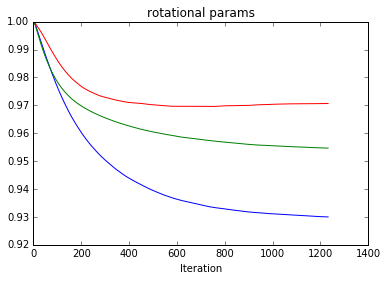

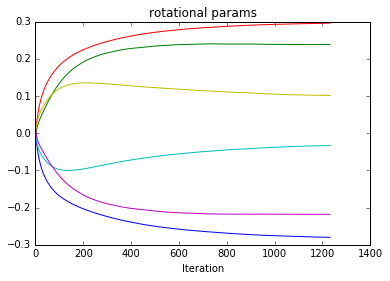

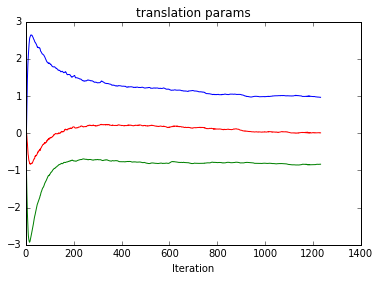

In [467]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,5,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [1,2,4,6,8,9]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
0.230113816238 0.230081351305
[[ 0.9313625  -0.27468814  0.23897766  0.99044471]
 [ 0.29188298  0.95565488 -0.03909071 -0.81022936]
 [-0.21764241  0.10616114  0.9702379   0.03480999]]


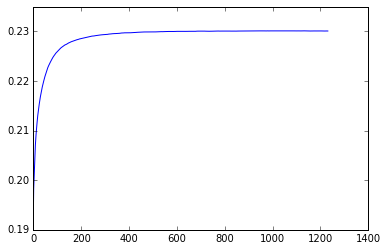

In [468]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

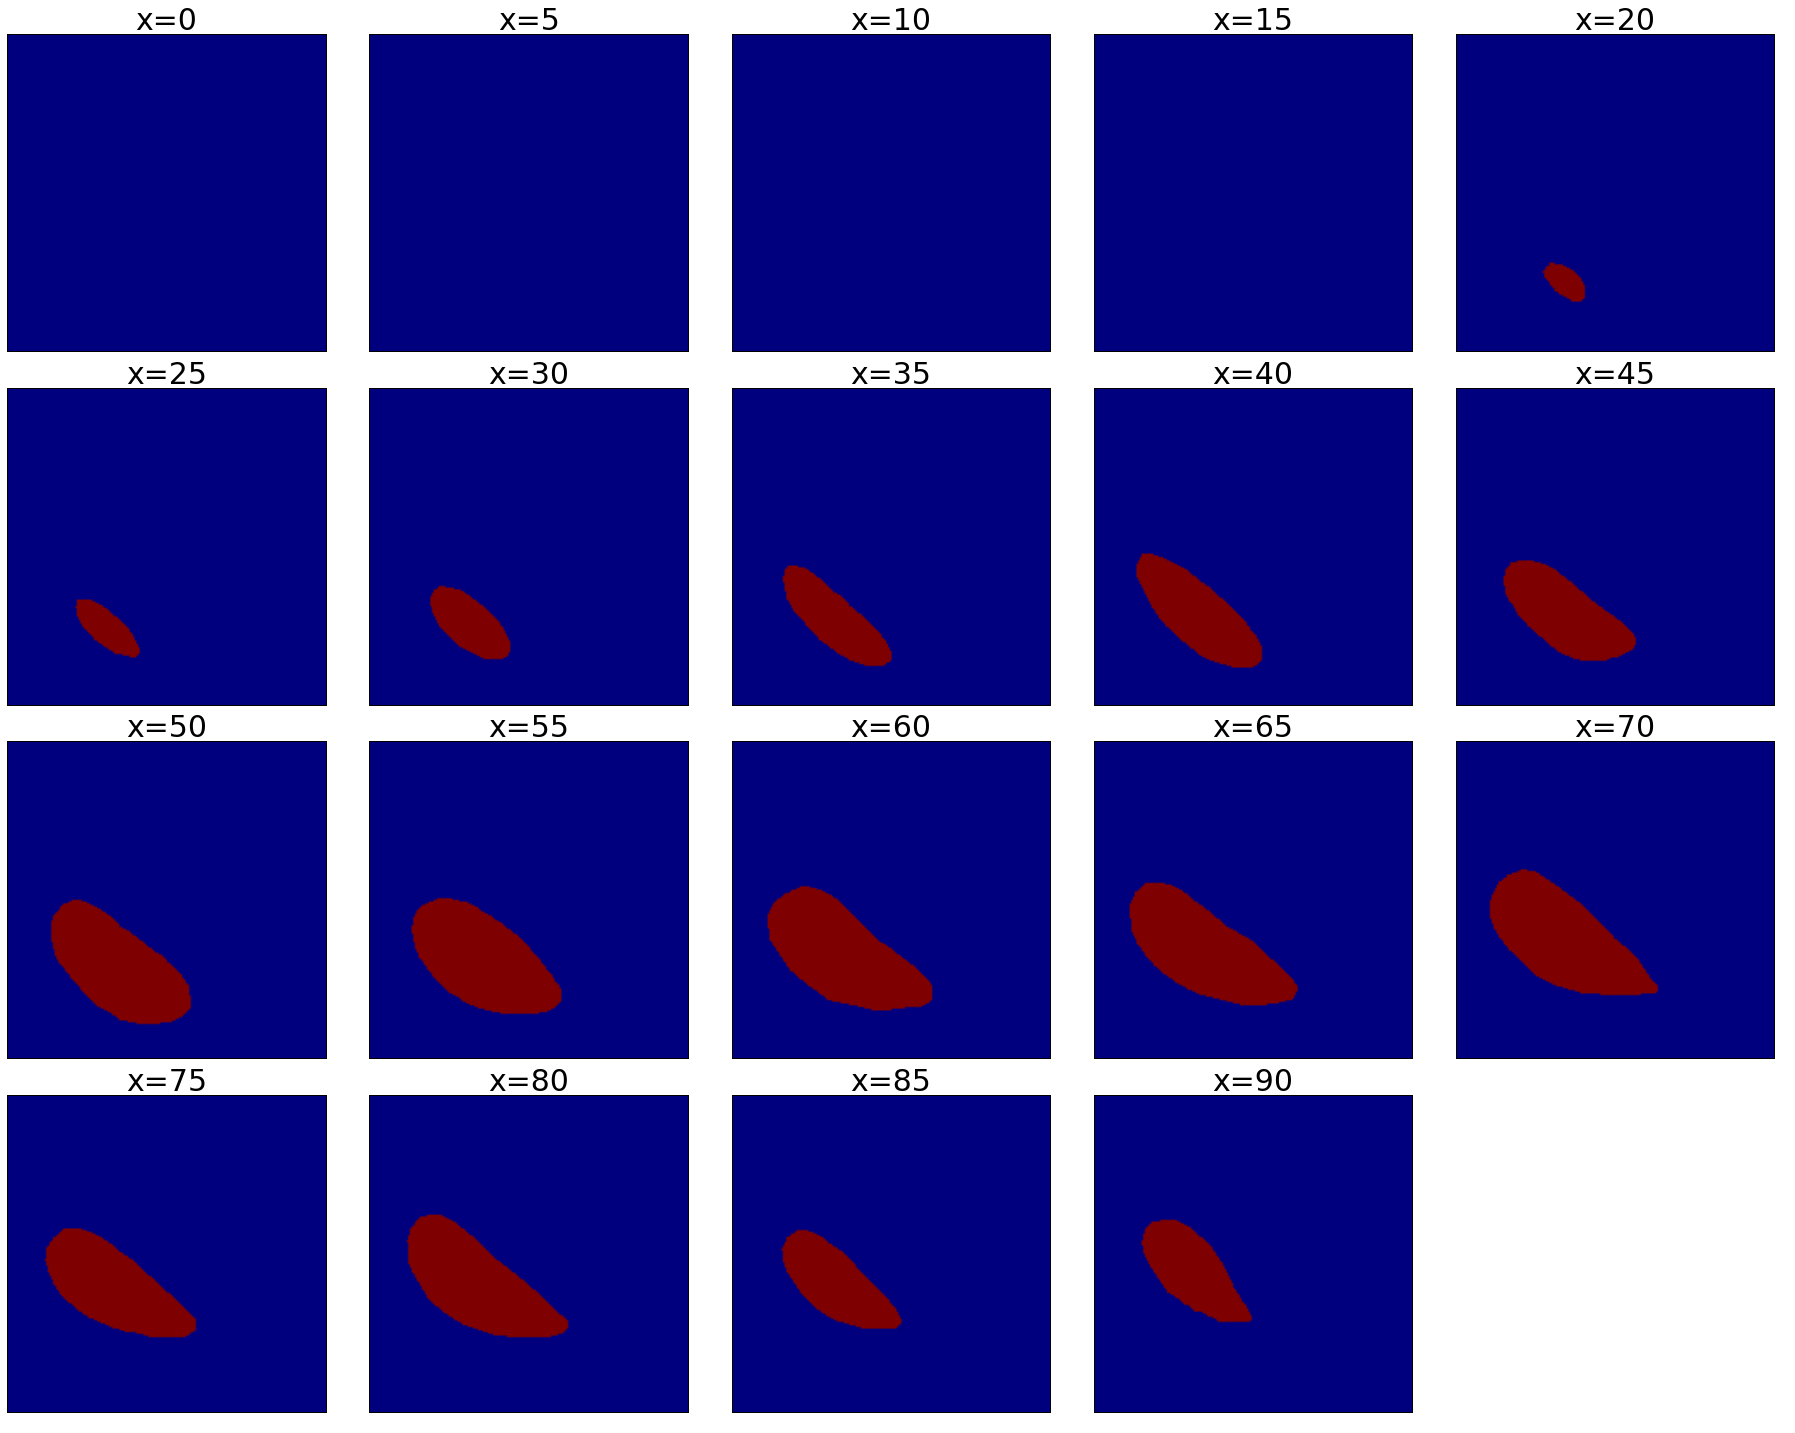

In [469]:
display_volume_sections(volume_fixed[structure_to_label_fixed[structure]], start_level=0, every=5, direction='x')

In [470]:
global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
DataManager.load_alignment_parameters(stack_f=stack_fixed, stack_m='atlasV5', warp_setting=24, vol_type_f='annotationAsScore')
G_movingvol2fixedvol = consolidate(params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)
print G_movingvol2fixedvol

[[  7.64209568e-01   2.16241503e-01   9.88827510e-05  -1.88836519e+01]
 [ -1.54801687e-01   1.13828874e+00  -1.65787052e-01  -9.44835160e+01]
 [  7.24395518e-02  -6.16445435e-02   1.04966111e+00  -2.48615153e+01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [471]:
local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [472]:
L = consolidate(params=local_params, centroid_m=centroid_m, centroid_f=centroid_f)
print L

[[  9.31362499e-01  -2.74688136e-01   2.38977664e-01   3.43030115e+01]
 [  2.91882983e-01   9.55654875e-01  -3.90907149e-02   4.24423278e+01]
 [ -2.17642414e-01   1.06161139e-01   9.70237905e-01   1.22045853e+01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [473]:
Q_movingvol2fixedvol = np.dot(L, G_movingvol2fixedvol - np.column_stack([np.zeros((4,3)), 
                                                  np.r_[volume_moving_bbox_rel2fixedvol[[0,2,4]], 0]]))
print Q_movingvol2fixedvol

# This is shared by all structures.
fixedvol_bbox_rel2fixedsubj = DataManager.load_original_volume_bbox(stack=stack_fixed, volume_type='annotationAsScore', structure='SNR_L',
                                      relative_to_uncropped=True)
print fixedvol_bbox_rel2fixedsubj

Q_movingvol2fixedsubj = Q_movingvol2fixedvol + np.column_stack([np.zeros((4,3)),
                                                                np.r_[fixedvol_bbox_rel2fixedsubj[[0,2,4]], 0]])
print Q_movingvol2fixedsubj

[[  7.71589755e-01  -1.26006856e-01   2.96477393e-01   2.27223825e+01]
 [  7.22910679e-02   1.15333813e+00  -1.99438345e-01  -1.02632878e+02]
 [ -1.12474740e-01   1.39688344e-02   1.00079934e+00  -2.56882830e+01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[ -17   99 -578 -392 2450 2637]
[[  7.71589755e-01  -1.26006856e-01   2.96477393e-01   5.72238250e+00]
 [  7.22910679e-02   1.15333813e+00  -1.99438345e-01  -6.80632878e+02]
 [ -1.12474740e-01   1.39688344e-02   1.00079934e+00   2.42431172e+03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [474]:
# pts_rel2fixedsubj = np.array([[   28.5326087 ,   801.51154891,  1332.56657609]])
# pts_rel2movingvol = np.dot(np.linalg.inv(Q_movingvol2fixedsubj), 
#              np.column_stack([pts_rel2fixedsubj, np.ones((len(pts_rel2fixedsubj),))]).T).T[:, :3]

# print pts_rel2movingvol

In [475]:
# Transform moving volume, sided, without surround

# structure = '3N_L'

# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving_in_bboxrel2fixedvol[structure_to_label_moving[structure]]

volume_m2fl_in_bboxrel2fixedvol, volume_m2fl_bbox_rel2fixedvol = \
transform_volume_v2(vol=vol_m, tf_params=local_params, centroid_m=centroid_m, centroid_f=centroid_f)

print volume_m2fl_bbox_rel2fixedvol

(17, 103, 59, 173, 13, 112)


Interpolating/filling sparse volume: 0.09 seconds.


In [476]:
# x1f,x2f,y1f,y2f,z1f,z2f = bbox_3d(volume_fixed[structure_to_label_fixed[structure]])
# sf = np.count_nonzero(volume_fixed[structure_to_label_fixed[structure]])

# plt.plot([np.count_nonzero(volume_m_alignedTo_f > t) for t in np.arange(0.0, 0.5, 0.01)]);
# plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
# plt.hlines(y=sf, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
# plt.xlabel('Probability cutoff');
# plt.ylabel('Volume');
# plt.show();

# plt.plot([bbox_3d(volume_m_alignedTo_f > t)[1] - bbox_3d(volume_m_alignedTo_f > t)[0] 
#           for t in np.arange(0.0, 0.5, 0.01)]);
# plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
# plt.hlines(y=x2f+1-x1f, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
# plt.xlabel('Probability cutoff');
# plt.ylabel('Size x');
# plt.show();

# plt.plot([bbox_3d(volume_m_alignedTo_f > t)[3] - bbox_3d(volume_m_alignedTo_f > t)[2] 
#           for t in np.arange(0.0, 0.5, 0.01)]);
# plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
# plt.hlines(y=y2f+1-y1f, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
# plt.xlabel('Probability cutoff');
# plt.ylabel('Size y');
# plt.show();

# plt.plot([bbox_3d(volume_m_alignedTo_f > t)[5] - bbox_3d(volume_m_alignedTo_f > t)[4] 
#           for t in np.arange(0.0, 0.5, 0.01)]);
# plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
# plt.hlines(y=z2f+1-z1f, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
# plt.xlabel('Probability cutoff');
# plt.ylabel('Size z');
# plt.show();

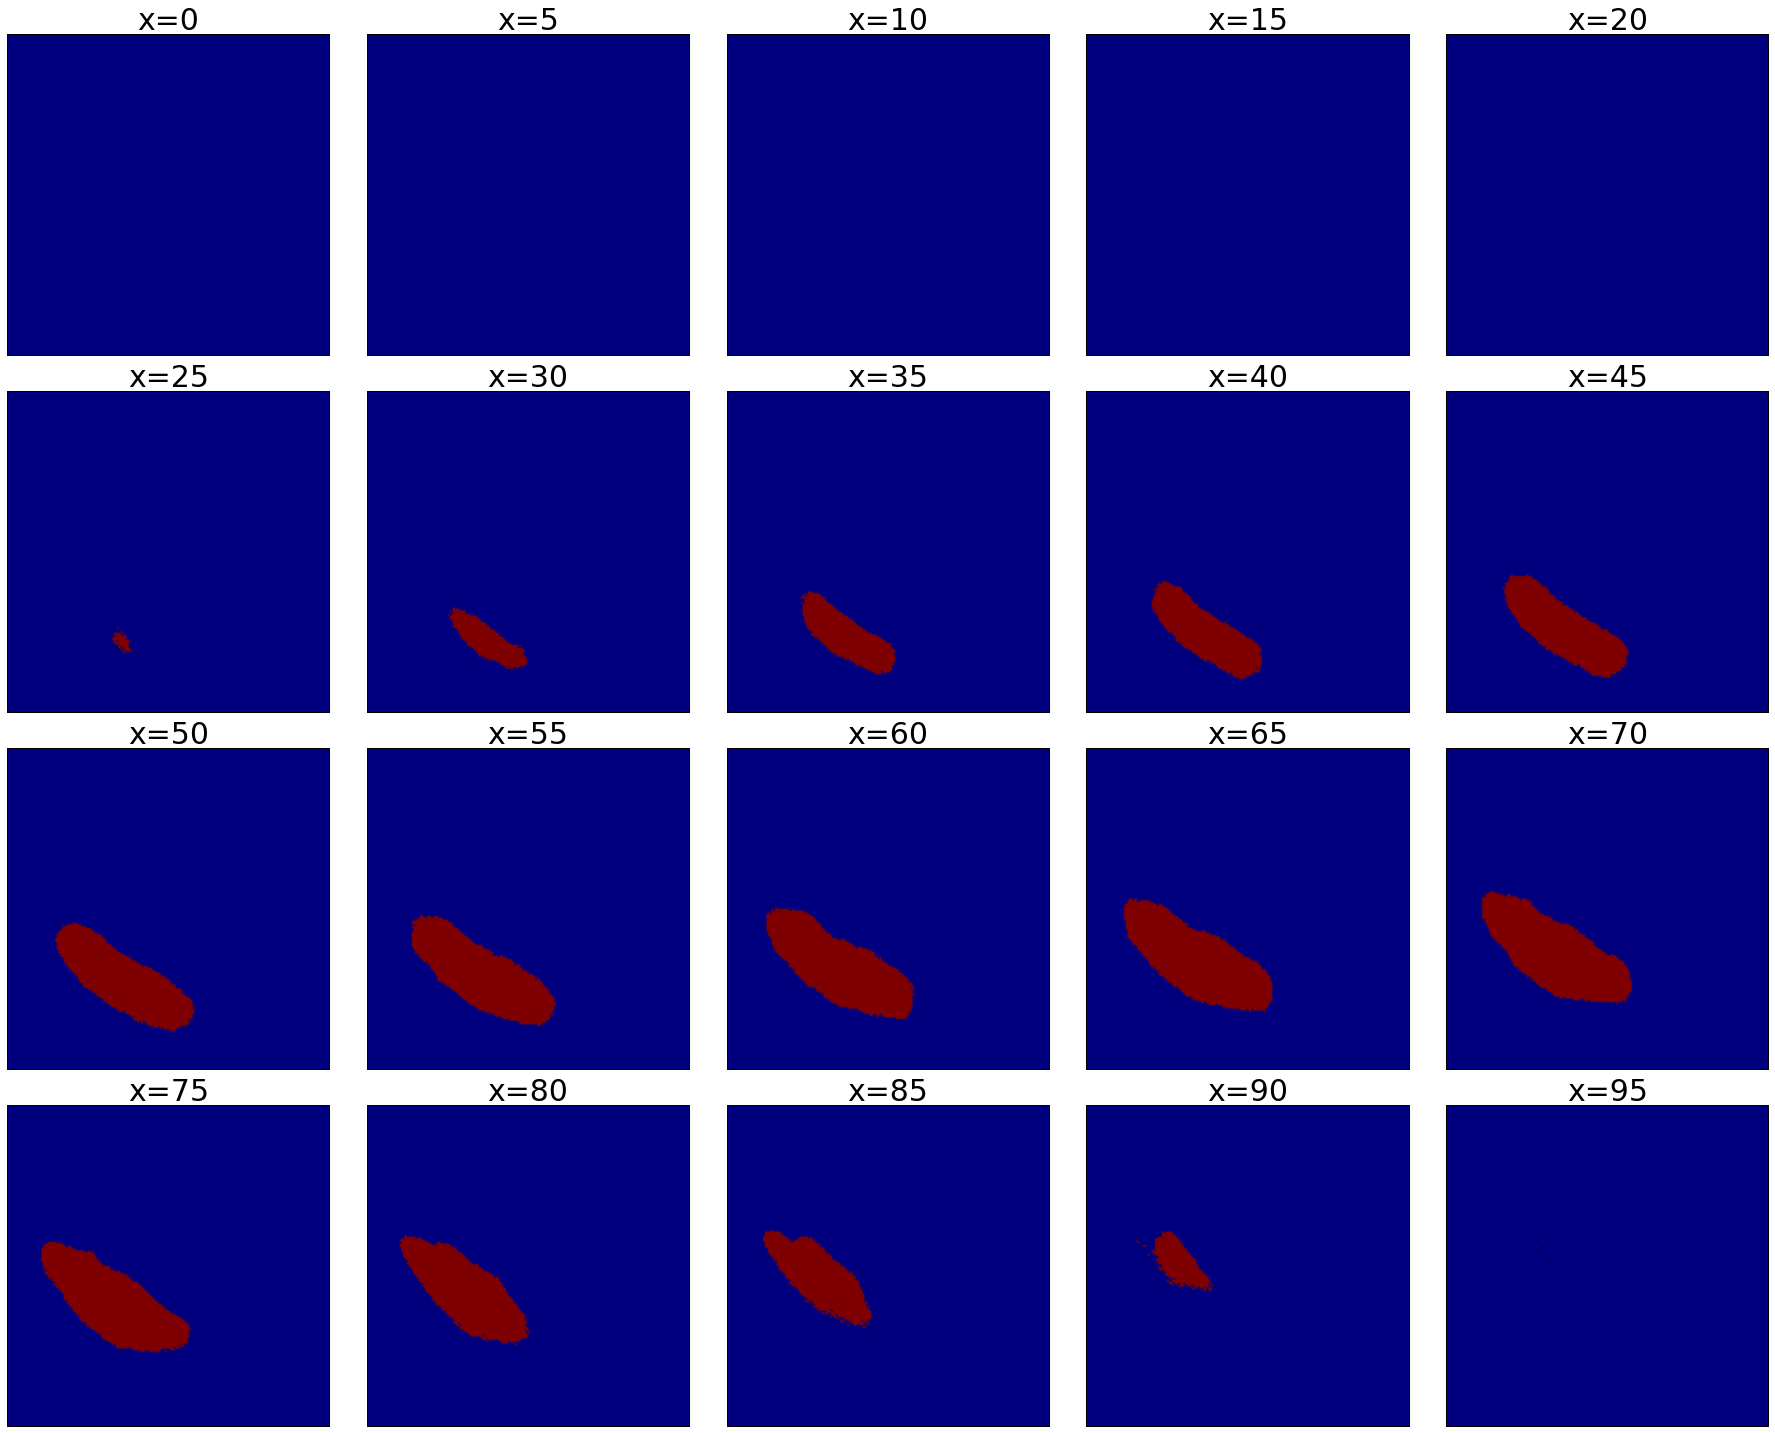

In [477]:
display_volume_sections(crop_and_pad_volume(volume_m2fl_in_bboxrel2fixedvol > 0.5, 
                                            in_bbox=volume_m2fl_bbox_rel2fixedvol,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1)), 
                        start_level=0,
                       direction='x')

In [478]:
# Warping all atlas structures.

volume_m2fl = {}
for label_m, vol_m in volume_moving_in_bboxrel2fixedvol.iteritems():
    
    volume_m2fl_in_bboxrel2fixedvol, volume_m2fl_bbox_rel2fixedvol = \
    transform_volume_v2(vol=vol_m, tf_params=local_params, centroid_m=centroid_m, centroid_f=centroid_f)

    volume_m2fl[label_m] = crop_and_pad_volume(volume_m2fl_in_bboxrel2fixedvol > 0.5, 
                                            in_bbox=volume_m2fl_bbox_rel2fixedvol,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1))

Interpolating/filling sparse volume: 0.16 seconds.
Interpolating/filling sparse volume: 0.21 seconds.


# draw

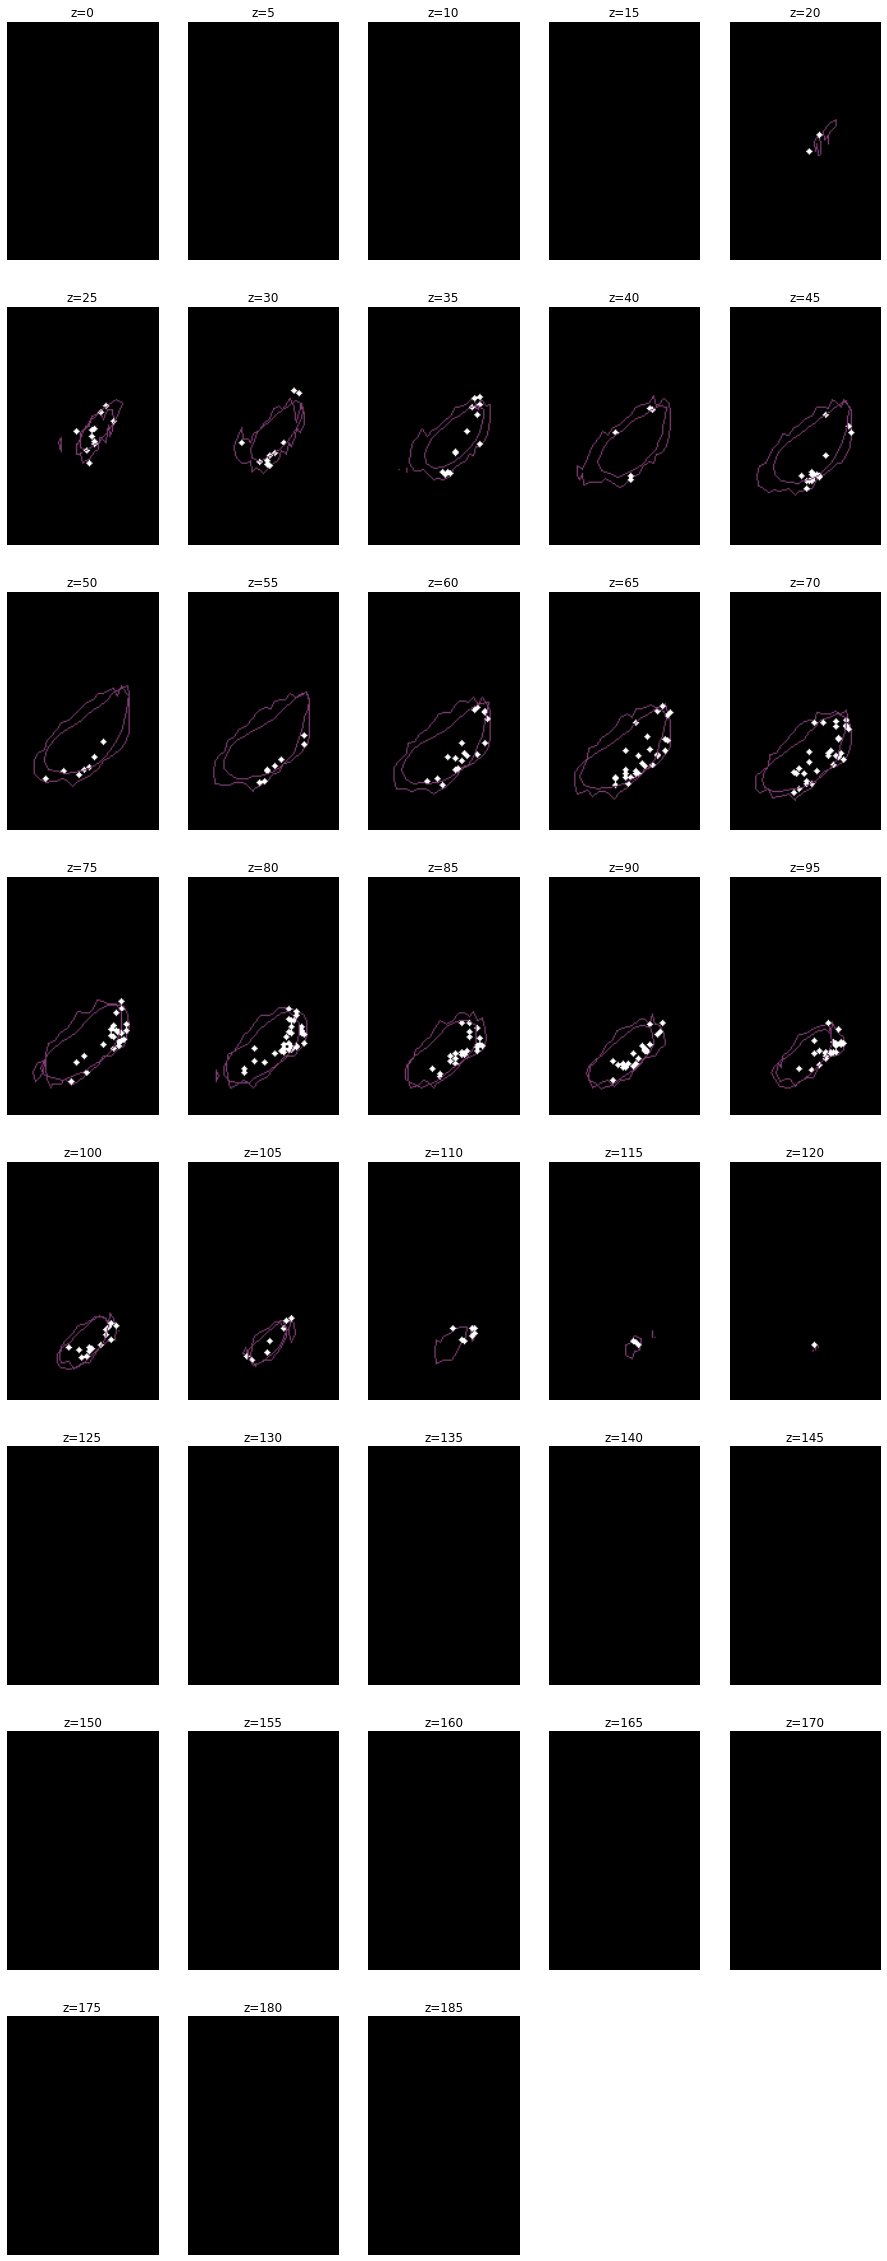

In [479]:
structures_to_draw = [l for l in volume_m2fl.keys() if not is_surround_label(label_to_structure_moving[l])]

colors = {l: name_unsided_to_color[convert_to_original_name(label_to_structure_fixed[l])]
for l in structures_to_draw}

draw_alignment(warped_atlas=volume_m2fl, fixed_volumes=volume_fixed, 
               zs=np.arange(0,volume_fixed.values()[0].shape[2],5), ncols=5,
              structures=structures_to_draw,
              colors=colors,
              markers=np.array(marker_xyzs_rel2fixedvol.values()))

In [480]:
# launch_vtk([actor_mesh(volume_to_polydata(volume_m2fl[1], num_simplify_iter=3, smooth=True),
#                        wireframe=True, color=(0,0,0)),
#             actor_mesh(volume_to_polydata(volume_fixed[1], num_simplify_iter=3, smooth=True), 
#                        wireframe=True, color=(0,1,0)),
#            ])

In [481]:
#########################
# Save the best trial
#########################

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]

# Save parameters
params_fp = \
    DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                          structure_f=structure,
                                                          structure_m=structure,
                                                  warp_setting=warp_setting,
                                              vol_type_f='annotationAsScore',
                                                 what='parameters')
DataManager.save_alignment_parameters(params_fp, T_all_trials[best_trial], 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
upload_to_s3(params_fp)

# Save score history
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure, 
                                              warp_setting=warp_setting,
                                                       vol_type_f='annotationAsScore',
                                             what='scoreHistory')
bp.pack_ndarray_file(np.array(scores_all_trials[best_trial]), history_fp)
upload_to_s3(history_fp)

# Save score plot
score_plot_fp = \
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure,
                                              warp_setting=warp_setting,
                                                       vol_type_f='annotationAsScore',
                                             what='scoreEvolution')
fig = plt.figure();
plt.plot(scores_all_trials[best_trial]);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)
upload_to_s3(score_plot_fp)

# Save trajectory
trajectory_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure,
                                                  warp_setting=warp_setting,
                                                          vol_type_f='annotationAsScore',
                                                 what='trajectory')
bp.pack_ndarray_file(np.array(traj_all_trials[best_trial]), trajectory_fp)
upload_to_s3(trajectory_fp)

aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp25_LM72_down32_annotationAsScoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp25_LM72_down32_annotationAsScoreVolume_SNR_L_parameters.txt" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp25_LM72_down32_annotationAsScoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp25_LM72_down32_annotationAsScoreVolume_SNR_L_parameters.txt"
aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp25_LM72_down32_annotationAsScoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp25_LM72_down32_annotationAsScoreVolume_SNR_L_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp25_LM72_down32_annotationAsScoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp25_LM72_down32_annotationAsScoreVolume_SNR_L_scoreHistory.bp"
aws s3 cp "/home/yuncong/C